# Cardio

## imports

In [1]:
import Utils
import pandas as pd
from pandas import concat, read_csv, Series
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from stats.HigherLevelRanksum import directed_mannwhitneyu
from scipy.stats.stats import spearmanr, pearsonr, mannwhitneyu
from scipy.stats import ttest_ind, kstest, ks_2samp
from scipy.spatial.distance import braycurtis, pdist, squareform, euclidean, cdist
from Analyses.MantelTest import test as mantel_test
import seaborn as sns
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from graphics.GraphHelper import do_PCoA
from skbio.stats.ordination._principal_coordinate_analysis import PCoA
from datetime import datetime
from skbio.stats.distance import DistanceMatrix
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GroupKFold
from sklearn import metrics
from Analyses.KEGGDataBuilder import *
import urllib2
from Bio import SeqIO

sns.set_style("darkgrid")
MIN_ABUNDANCE = 1e-7
MIN_ABUNDANCE_GENES = 1e-8

os.chdir('/home/noamba/Analyses/Noamba/Cardio/Cardio07112017/')

## functions

In [2]:
def print_plus(i):
    print str(datetime.now()) + str(i[0])
    i[0] += 1

def clip_min_max(df):
    return df.clip(lower = df.quantile(2./df.shape[0]), upper = df.quantile(float(df.shape[0]-1)/df.shape[0]), axis = 1).copy()

def count_spread(arr, resolution=0.5):
    return len(set([int(r/resolution) for r in arr[~np.isnan(arr)]]))

def compute_moving_average(x, window_size=100, method=np.median):
    if window_size >= len(x):
        return [method(x)] * len(x)
    conv_vals = []
    for i in range(len(x)):
        conv_vals += [method(x[max(0,i-window_size/2):i+window_size/2])]
    return np.array(conv_vals)

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

def BrayCurtis(X):
    return braycurtis(X[0,:], X[1:,])

def compute_distance_matrix(samps_by_features, distance_meausere, do_binary = False):
    A = samps_by_features.T.copy()
    temp_res = pd.DataFrame(1, index=A.columns, columns=A.columns, dtype=np.float64)
    A = A.values
    if do_binary:
        A[A>0] = 1
    for i in range(A.shape[1]):
        a = A[:,i]
        vals = []
        if i % 10 == 0:
            print i
        for j in range(A.shape[1]):
            b = A[:,j]
            val = None
            val = distance_meausere(np.stack((a,b),axis=1).T)
            vals.append(val)
        temp_res.iloc[i,:] = vals
    return temp_res

def break_joined_index(df, first_id = 'FD', second_id = 'SPID'):
    a = df.copy()
    a = pd.concat((a.reset_index(drop = True), a.reset_index()['index'].str.split('_').apply(Series).rename(columns = {0:first_id, 1:second_id})), axis = 1)
    a[second_id] = a[second_id].astype(int) 
    return a.sort_values([second_id, first_id]).set_index([second_id, first_id])

def runPCA(data, n_components=10):
    tmat = data.transpose()
    pca = PCA(n_components = n_components)
    print (str(datetime.now()) + " - Running PCA - this should take some time...") 
    tmat_pca = pca.fit_transform(tmat)
    print (str(datetime.now()) + " - Running PCA - done") 
    return tmat_pca

def find_n_minimal_values(arr, n):
    temp = pd.DataFrame(arr, index=range(len(arr)), columns=['val'])
    temp = temp.sort_values('val')
    return list(temp.iloc[0:n,:].index)

def read_fasta_to_dict(path):
    return {rec.id : rec.seq.__str__() for rec in SeqIO.parse(path, "fasta")}

def build_fasta_file_for_KEGG_compartments(fasta_dict, kegg_obj, kos_genes_dict, output_path, pathways=None, reactions=None, modules=None, kos=None):
    all_genes = []
    kegg_ids = {'pathway':'path:map', 'reaction':'rn:R', 'module':'md:M'}
    kegg_dict = {'pathway':pathways, 'reaction':reactions, 'module':modules}
    
    for k in kegg_dict:
        if kegg_dict[k] is None:
            continue
        for p in kegg_dict[k]:
            pw = kegg_ids[k] + p
            print pw
            temp_kos = kegg_obj.get_dicts()[k + '_ko'][pw]
            for ko in temp_kos:
                if ko in kos_genes_dict:
                    temp_genes = kos_genes_dict[ko]
                    for g in temp_genes:
                        if g in fasta_dict:      
                            all_genes.append(g)
        print len(all_genes)
        if kos is not None:
            for ko in kos:
                if ko in kos_genes_dict:
                    temp_genes = kos_genes_dict[ko]
                    for g in temp_genes:
                        if g in fasta_dict:      
                            all_genes.append(g)
        print len(all_genes)
    with open(output_path, 'w') as handle:
        for g in set(all_genes):
            handle.write('>' + g + '\n')
            handle.write(fasta_dict[g] + '\n')
    return

In [3]:
dataframes = [f for f in os.listdir('DFOut/') if re.match('.+.dat', f)]
Cardio_dfs = {k.split('.dat')[0]:Utils.Load('DFOut/' + k) for k in dataframes}

In [4]:
Cardio_dfs.keys()

['MPACountSpid',
 'NogGeneSpidDF',
 'EMGenes',
 'MPASpid',
 'ReadCountSpidDF',
 'KeggGeneSpidDF',
 'MappedGenesetSpidDF',
 'PreUniteReadCountDF']

## read sample sheet

In [32]:
# sample_sheet = pd.read_csv('../Sample_sheet_01_11_2017.csv')
sample_sheet = pd.read_csv('../Sample_sheet_12_11_2017.csv')
sample_sheet.columns = [c.strip() for c in sample_sheet.columns]
del sample_sheet['Unnamed: 0']
fds = ['FD' + fd.split('FD')[1] for fd in sample_sheet.Sample.values]
participent_id = [int(fd.split('FD')[0]) for fd in sample_sheet.Sample.values]

sample_sheet['FD'] = fds
sample_sheet['ParticipentID'] = participent_id
sample_sheet_by_FD = sample_sheet.set_index('FD').copy()
sample_sheet['Comments'].unique()
samples_validity = {}
samples_validity['Need re-Seq'] = sample_sheet[sample_sheet.Comments == 'Need re-Seq'].FD.values
samples_validity['Need re-Nextera'] = sample_sheet[sample_sheet.Comments == 'Need re-Nextera'].FD.values
samples_validity['do not process'] = sample_sheet[sample_sheet.Comments == 'do not process'].FD.values
# samples_validity['valid'] = sample_sheet[sample_sheet.Comments.isnull()].FD.values
samples_validity['valid'] = np.array([fd for fd in Cardio_dfs['ReadCountSpidDF'].reset_index().FD.values[Cardio_dfs['ReadCountSpidDF']['PostSubSamp'] > 8500000] if re.match('FD.+', fd)])
len(samples_validity['valid'])

101

## Compute correct mapping percentages

In [6]:
Cardio_dfs['ReadCountSpidDF']['GeneSetMap_Perc'] = Cardio_dfs['ReadCountSpidDF']['GeneSetMap_Count'].values / Cardio_dfs['ReadCountSpidDF']['PostSubSamp'].values
Cardio_dfs['ReadCountSpidDF']['FullGenomeMap_Perc'] = Cardio_dfs['ReadCountSpidDF']['FullGenomeMap_Count'].values / Cardio_dfs['ReadCountSpidDF']['PostSubSamp'].values

## screen out of the lab samples

In [7]:
ReadCountSpidDF = Cardio_dfs['ReadCountSpidDF'].reset_index(drop=False)
ReadCountSpidDF = ReadCountSpidDF[ReadCountSpidDF.SPID != -1]
Cardio_dfs['ReadCountSpidDF'] = ReadCountSpidDF.set_index(['SPID', 'FD', 'PE/SE'])
cardio_valid_ReadCountSpidDF = Cardio_dfs['ReadCountSpidDF'].iloc[Cardio_dfs['ReadCountSpidDF'].index.get_level_values('FD').isin(samples_validity['valid'])].reset_index('PE/SE')
cardio_fd_spid = cardio_valid_ReadCountSpidDF.reset_index()
cardio_fd_spid['FD_SPID'] = cardio_fd_spid['FD'].astype(str) + '_' +cardio_fd_spid['SPID'].astype(str)

In [8]:
Cardio_dfs.keys()

['MPACountSpid',
 'NogGeneSpidDF',
 'EMGenes',
 'MPASpid',
 'ReadCountSpidDF',
 'KeggGeneSpidDF',
 'MappedGenesetSpidDF',
 'PreUniteReadCountDF']

## parse Medical questionnaire

In [47]:
cardio_medical_q = pd.read_excel('../Cardio07112017/Microbiome_Cardio_medical_questionais.xlsx')
cardio_medical_q = cardio_medical_q.set_index(cardio_medical_q.columns[1])
cardio_medical_q = cardio_medical_q.loc[sample_sheet_by_FD.loc[cardio_fd_spid.FD].ParticipentID].dropna(how='all', axis=1)

In [50]:
cardio_medical_q.index.value_counts()

3516850    2
3870438    2
3899391    1
3035995    1
3477351    1
3985473    1
3736997    1
3716167    1
3749960    1
3863603    1
3703636    1
3457111    1
3697558    1
3935580    1
3248185    1
3175261    1
3523680    1
3849571    1
3677285    1
3026535    1
3318888    1
3434612    1
3282295    1
3168327    1
3485604    1
3140993    1
3030457    1
3040383    1
3204663    1
3923715    1
          ..
3681782    1
3307767    1
3212387    1
3441148    1
3660222    1
3610542    1
3100670    1
3447991    1
3688322    1
3401349    1
3351948    1
3825462    1
3808142    1
3443343    1
3807632    1
3864468    1
3493526    1
3632535    1
3651482    1
3744412    1
3583645    1
3031317    1
3705508    1
3161253    1
3944870    1
3775911    1
3278763    1
3512238    1
3742133    1
3068162    1
Name: מספר משתתף, Length: 101, dtype: int64

In [18]:
w = pd.DataFrame(0, index=range(2000), columns=['s', 'e'])
w['s'] = [0] * 2000
w['e'] = [4000] * 2000
arr = np.zeros((4,3000000))

In [26]:
start = datetime.now()
for i in range(200):
#     print datetime.now()
    for ind, row in w.iterrows():
        e = arr[:,row['s']:row['e']].mean().mean()
#         print row
#         break
#     break
end = datetime.now()

print end-start

0:01:13.732711


In [14]:
np.random.randint(0,10,4)

array([6, 6, 3, 6])

## read the joined EM matrix

In [1363]:
joined_em = read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/control_em/EMGenes_joined.csv')

In [1374]:
joined_em = joined_em.set_index('Unnamed: 0')
joined_em_all = joined_em.copy()

In [1375]:
joined_em.min().min()

1.0594231784799999e-08

## Count number of genes/species per sample

In [12]:
genes_count_df = pd.DataFrame(Cardio_dfs['EMGenes'][cardio_fd_spid.FD_SPID].notnull().sum().values, index=Cardio_dfs['EMGenes'][cardio_fd_spid.FD_SPID].columns, columns=['GeneCount'])
MPA_count_df = pd.DataFrame(Cardio_dfs['MPASpid'][cardio_fd_spid.FD_SPID].notnull().sum().values, index=Cardio_dfs['MPASpid'][cardio_fd_spid.FD_SPID].columns, columns=['MPACount'])
Cardio_dfs['MappingCount'] = pd.concat((genes_count_df, MPA_count_df), axis=1).dropna()

In [13]:
Cardio_dfs['MappingCount'] = break_joined_index(Cardio_dfs['MappingCount'])
Cardio_dfs['MappingCount'] .head()

,,GeneCount,MPACount
SPID,FD,,
1334,FD2429,65709,358
1335,FD2439,147581,289
1336,FD2453,138525,297
1337,FD2448,107686,263
1338,FD2436,118119,252


In [2039]:
ReadCountSpidDF[ReadCountSpidDF.FD == 'FD2505']

,SPID,FD,PE/SE,RegistrantNumber,PostQC,RawReads,HGMapped,PostHGF,Exp,PostSubSamp,GeneSetMap_Count,GeneSetMap_Perc,FullGenomeMap_Count,FullGenomeMap_Perc
106,1419,FD2505,SE,3452236,12353916.0,12859615,6285875.0,6068041.0,"2017-10-25-D2-Cardio, 2017-10-30-Cardio",6068041.0,4598518,0.757826,1310927,0.216038


## distance matrices

In [1377]:
# cardio_em = joined_em[cardio_fd_spid.FD_SPID].fillna(0)
cardio_MPA = Cardio_dfs['MPASpid'][cardio_fd_spid.FD_SPID].fillna(0)
# cardio_em_log = joined_em[cardio_fd_spid.FD_SPID].fillna(MIN_ABUNDANCE_GENES)
cardio_MPA_log = Cardio_dfs['MPASpid'][cardio_fd_spid.FD_SPID].fillna(MIN_ABUNDANCE)

KeyboardInterrupt: 

In [993]:
cardio_em_log = cardio_em.apply(np.log10)
cardio_MPA_log = cardio_MPA_log.apply(np.log10)

## Izhak DIAMOND

In [184]:
izhak_diamond_cardio = Utils.Load('../../Cardio_DF_KOs_DIAMOND_threshold_0.1')

In [22]:
Utils.Write('Izhak_DIAMOND_cardio_101samps.dat', izhak_diamond_cardio.loc[cardio_fd_spid.FD_SPID])

# PNP data

In [25]:
PNP_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/AllSeqProjects/DFOut/'
relevant_files = ['MappedGenesetSpidDF.dat', 'StoolMetadataDF.dat', 'MPASpid.dat', 'PreUniteReadCountDF.dat', 'MappedGenesetDF.dat', 'MPA.dat', 'ReadCountSpidDF.dat', 'ReadCountDF.dat']
PNP_dataframes = [f for f in relevant_files if re.match('.+.dat', f)]
PNP_dfs = {k.split('.dat')[0]:Utils.Load(PNP_dir + k) for k in PNP_dataframes}
study_type_used = 1
sample_type = 0
blacklisted = 0
min_number_of_raw_reads = 9500000

## choose relevant samples from PNP

In [26]:
relevant_pnp = PNP_dfs['StoolMetadataDF'][PNP_dfs['StoolMetadataDF'].IsGenotek == sample_type]
relevant_pnp = relevant_pnp[relevant_pnp.blacklisted == blacklisted]
relevant_pnp = relevant_pnp[relevant_pnp.StudyTypeID == study_type_used]
relevant_pnp = relevant_pnp[~relevant_pnp.RawReads.isnull()]
relevant_pnp = relevant_pnp[relevant_pnp.RawReads > min_number_of_raw_reads]
pnp_fd_cnid = relevant_pnp.reset_index()
pnp_fd_cnid['FD_ConnectionID'] = pnp_fd_cnid['FD'].astype(str) + '_' +pnp_fd_cnid['ConnectionID'].astype(str)

In [27]:
mpa = PNP_dfs['MappedGenesetSpidDF'].copy()
mpa = mpa.reset_index()
mpa.columns = ['FD_SPID', mpa.columns[1]]
mpa['FD'] = [s.split('_')[0] for s in mpa['FD_SPID']]
mpa['SPID'] = [s.split('_')[1] for s in mpa['FD_SPID']]
pnp_fd_cid_spid = pd.merge(pnp_fd_cnid, mpa, on='FD')
# d = {s.split('_')[0]:s.split('_')[1] for s in mpa.columns}
Utils.Write('../control_em/pnp_fd_spid.dat', list(pnp_fd_cid_spid.FD_SPID))

## compute correct mapping percentages

In [180]:
GeneSetMap_Perc = [relevant_pnp.iloc[s, :]['GeneSetMap_Count']/min(10000000., relevant_pnp.iloc[s, :]['PostHGF']) for s in range(relevant_pnp.shape[0])]
FullGenomeMap_Perc = [relevant_pnp.iloc[s, :]['FullGenomeMap_Count']/min(10000000., relevant_pnp.iloc[s, :]['PostHGF']) for s in range(relevant_pnp.shape[0])]
relevant_pnp['GeneSetMap_Perc'] = GeneSetMap_Perc
relevant_pnp['FullGenomeMap_Perc'] = FullGenomeMap_Perc

## distance matrices

In [995]:
# pnp_em = PNP_dfs['EMGenes'][pnp_fd_cid_spid.FD_SPID.values].fillna(0)
# pnp_em = joined_em[pnp_fd_cid_spid.FD_SPID.values].fillna(0)
pnp_MPA = PNP_dfs['MPA'][pnp_fd_cnid.FD_ConnectionID.values].fillna(0)
# pnp_em_log = joined_em[pnp_fd_cid_spid.FD_SPID.values].fillna(MIN_ABUNDANCE_GENES)
pnp_MPA_log = PNP_dfs['MPA'][pnp_fd_cnid.FD_ConnectionID.values].fillna(MIN_ABUNDANCE)

In [996]:
# pnp_em_log = pnp_em.apply(np.log10)
pnp_MPA_log = pnp_MPA_log.apply(np.log10)

# Analysis

## density of full genome mapping percentage

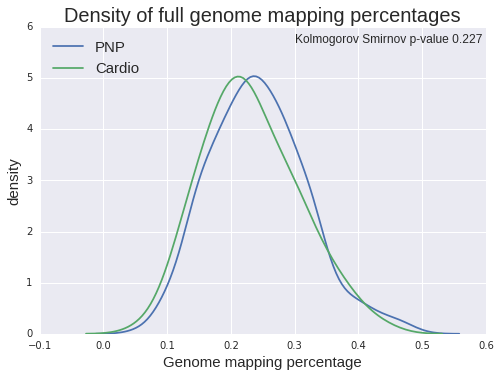

In [2008]:
sns.distplot(relevant_pnp['FullGenomeMap_Perc'], hist=False, label='PNP')
sns.distplot(cardio_valid_ReadCountSpidDF['FullGenomeMap_Perc'], hist=False, label='Cardio')
plt.xlabel('Genome mapping percentage', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.title('Density of full genome mapping percentages', fontsize=20)
plt.legend(loc='upper left', fontsize=15)

# gm_tt = ttest_ind(relevant_pnp['FullGenomeMap_Perc'].values.ravel(), cardio_valid_ReadCountSpidDF['FullGenomeMap_Perc'].values.ravel())
# gm_mw = directed_mannwhitneyu(relevant_pnp['FullGenomeMap_Perc'].values.ravel(), cardio_valid_ReadCountSpidDF['FullGenomeMap_Perc'].values.ravel())
gm_ks = ks_2samp(relevant_pnp['FullGenomeMap_Perc'].values.ravel(), cardio_valid_ReadCountSpidDF['FullGenomeMap_Perc'].values.ravel())

plt.text(0.3, 5.7, "Kolmogorov Smirnov p-value " + '%s' % float('%.3g' % gm_ks[1]))
plt.savefig('figs/FullGenome_mapping_per.png')
plt.show()

## density of gene mapping percentage

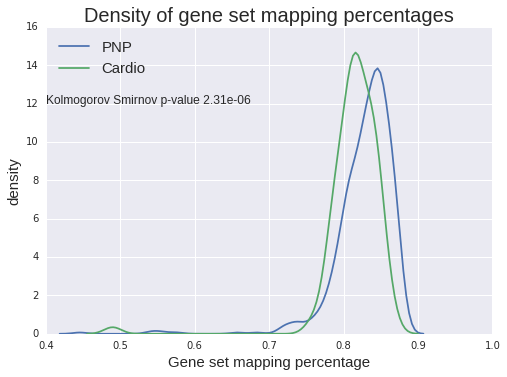

In [2009]:
sns.distplot(relevant_pnp['GeneSetMap_Perc'], hist=False, label='PNP')
sns.distplot(cardio_valid_ReadCountSpidDF['GeneSetMap_Perc'], hist=False, label='Cardio')
plt.xlabel('Gene set mapping percentage',  fontsize=15)
plt.ylabel('density', fontsize=15)
plt.title('Density of gene set mapping percentages', fontsize=20)
plt.legend(loc='upper left', fontsize=15)

# gsm_tt = ttest_ind(relevant_pnp['GeneSetMap_Perc'].values.ravel(), cardio_valid_ReadCountSpidDF['GeneSetMap_Perc'].values.ravel())
# gsm_mw = directed_mannwhitneyu(relevant_pnp['GeneSetMap_Perc'].values.ravel(), cardio_valid_ReadCountSpidDF['GeneSetMap_Perc'].values.ravel())
gsm_ks = ks_2samp(relevant_pnp['GeneSetMap_Perc'].values.ravel(), cardio_valid_ReadCountSpidDF['GeneSetMap_Perc'].values.ravel())

plt.text(0.4, 12, "Kolmogorov Smirnov p-value " + '%s' % float('%.3g' % gsm_ks[1]))
plt.savefig('figs/GeneSet_mapping_per.png')
plt.show()

## density of human mapping percentage

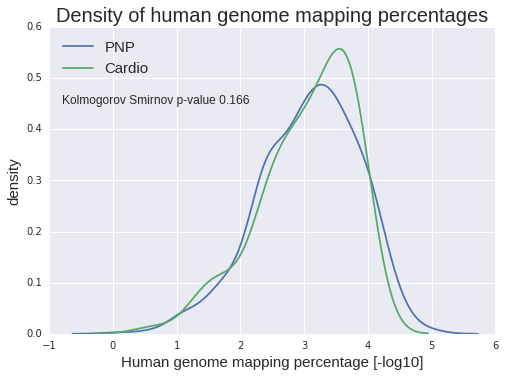

In [2010]:
cardio_valid_ReadCountSpidDF['HGMap_Perc'] = cardio_valid_ReadCountSpidDF.HGMapped / cardio_valid_ReadCountSpidDF.RawReads
relevant_pnp['HGMap_Perc'] = relevant_pnp.HGMapped / relevant_pnp.RawReads

sns.distplot(-np.log10(relevant_pnp['HGMap_Perc'].values), hist=False, label='PNP')
sns.distplot(-np.log10(cardio_valid_ReadCountSpidDF['HGMap_Perc']), hist=False, label='Cardio')
plt.xlabel('Human genome mapping percentage [-log10]',  fontsize=15)
plt.ylabel('density', fontsize=15)
plt.title('Density of human genome mapping percentages', fontsize=20)
plt.legend(loc='upper left', fontsize=15)

# gsm_tt = ttest_ind(relevant_pnp['GeneSetMap_Perc'].values.ravel(), cardio_valid_ReadCountSpidDF['GeneSetMap_Perc'].values.ravel())
# gsm_mw = directed_mannwhitneyu(relevant_pnp['GeneSetMap_Perc'].values.ravel(), cardio_valid_ReadCountSpidDF['GeneSetMap_Perc'].values.ravel())
hm_ks = ks_2samp(relevant_pnp['HGMap_Perc'].values.ravel(), cardio_valid_ReadCountSpidDF['HGMap_Perc'].values.ravel())

plt.text(-0.8, 0.45, "Kolmogorov Smirnov p-value " + '%s' % float('%.3g' % hm_ks[1]))
plt.savefig('figs/Human_mapping_per.png')
plt.show()

## density of number of species/genes

In [285]:
# pnp_genes_count_df = pd.DataFrame(PNP_dfs['EMGenes'][pnp_fd_cnid.FD_ConnectionID.values].notnull().sum().values, index=PNP_dfs['EMGenes'][pnp_fd_cnid.FD_ConnectionID.values].columns, columns=['GeneCount'])
pnp_MPA_count_df = pd.DataFrame(PNP_dfs['MPA'][pnp_fd_cnid.FD_ConnectionID.values].notnull().sum().values, index=PNP_dfs['MPA'][pnp_fd_cnid.FD_ConnectionID.values].columns, columns=['MPACount'])
# PNP_dfs['MappingCount'] = pd.concat((pnp_genes_count_df, pnp_MPA_count_df), axis=1).dropna()

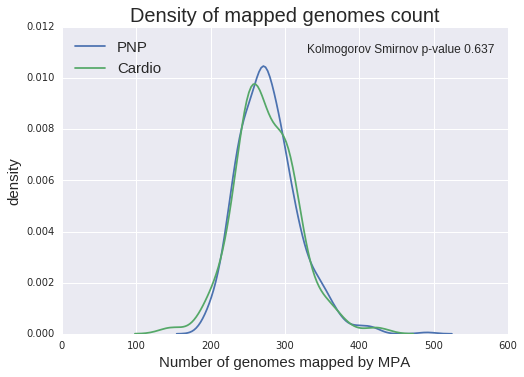

In [2011]:
sns.distplot(pnp_MPA_count_df, hist=False, label='PNP')
sns.distplot(Cardio_dfs['MappingCount'].loc[cardio_valid_ReadCountSpidDF.index]['MPACount'], hist=False, label='Cardio')
plt.xlabel('Number of genomes mapped by MPA',  fontsize=15)
plt.ylabel('density', fontsize=15)
plt.title('Density of mapped genomes count', fontsize=20)
plt.legend(loc='upper left', fontsize=15)

# mg_tt = ttest_ind(pnp_MPA_count_df.values.ravel(), Cardio_dfs['MappingCount'].loc[cardio_valid_ReadCountSpidDF.index]['MPACount'].values.ravel())
# mg_mw = directed_mannwhitneyu(pnp_MPA_count_df.values.ravel(), Cardio_dfs['MappingCount'].loc[cardio_valid_ReadCountSpidDF.index]['MPACount'].values.ravel())
mg_ks = ks_2samp(pnp_MPA_count_df.values.ravel(), Cardio_dfs['MappingCount'].loc[cardio_valid_ReadCountSpidDF.index]['MPACount'].values.ravel())

plt.text(330, 0.011, "Kolmogorov Smirnov p-value " + '%s' % float('%.3g' % mg_ks[1]))
plt.savefig('figs/Genomes_count_MPA.png')
plt.show()

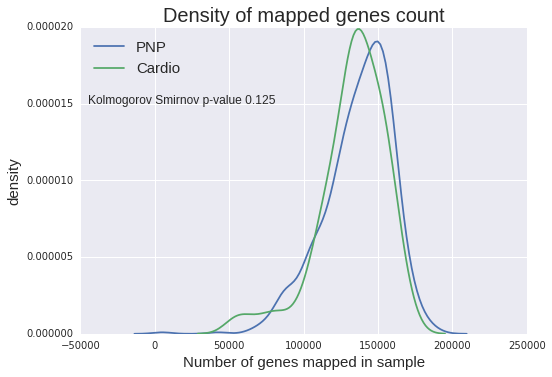

In [2012]:
# run this when genes em for pnp ends
pnp_genes_count_df = Utils.Load('../control_em/n_genes_pnp.dat')
sns.distplot(pnp_genes_count_df, hist=False, label='PNP')
sns.distplot(Cardio_dfs['MappingCount'].loc[cardio_valid_ReadCountSpidDF.index]['GeneCount'], hist=False, label='Cardio')
plt.xlabel('Number of genes mapped in sample',  fontsize=15)
plt.ylabel('density', fontsize=15)
plt.title('Density of mapped genes count', fontsize=20)
plt.legend(loc='upper left', fontsize=15)

# gc_tt = ttest_ind(pnp_genes_count_df.values.ravel(), Cardio_dfs['MappingCount'].loc[cardio_valid_ReadCountSpidDF.index]['GeneCount'].values.ravel())
# gc_mw = directed_mannwhitneyu(pnp_genes_count_df.values.ravel(), Cardio_dfs['MappingCount'].loc[cardio_valid_ReadCountSpidDF.index]['GeneCount'].values.ravel())
gc_ks = ks_2samp(pnp_genes_count_df, Cardio_dfs['MappingCount'].loc[cardio_valid_ReadCountSpidDF.index]['GeneCount'].values.ravel())

plt.text(-45000, 0.000015, "Kolmogorov Smirnov p-value " + '%s' % float('%.3g' % gc_ks[1]))
plt.savefig('figs/Gene_count.png')
plt.show()

## Distance matrices

### build merged distance matrices

In [1181]:
joined_MPA = pd.concat((pnp_MPA, cardio_MPA), axis=1).fillna(0)
joined_MPA_all = joined_MPA.copy()
joined_MPA_all_log = joined_MPA_all.copy()
joined_MPA_all_log[joined_MPA_all_log == 0] = np.nan
joined_MPA_all_log = joined_MPA_all_log.fillna(MIN_ABUNDANCE)
joined_MPA_all_log = joined_MPA_all_log.apply(np.log10)

joined_MPA[joined_MPA == 0] = np.nan
rare_function_idx = (joined_MPA.notnull().sum(1) >= 20)
joined_MPA = joined_MPA.loc[rare_function_idx]
joined_MPA = joined_MPA.fillna(0)

joined_MPA_log = pd.concat((pnp_MPA_log, cardio_MPA_log), axis=1).fillna(np.log10(MIN_ABUNDANCE))
joined_MPA_log = joined_MPA_log.loc[rare_function_idx]

In [1378]:
print datetime.now()
rare_function_idx = (joined_em_all.notnull().sum(1) >= 20)
print datetime.now()
joined_em_log = joined_em_all.loc[rare_function_idx]
print datetime.now()
joined_em_log = joined_em_log.fillna(MIN_ABUNDANCE_GENES).apply(np.log10)
print datetime.now()
joined_em = joined_em.loc[rare_function_idx].fillna(0)

2017-11-15 21:04:18.837590
2017-11-15 21:07:02.332419
2017-11-15 21:07:11.177756
2017-11-15 21:08:39.098922


In [1794]:
joined_em_binary = joined_em.copy()
joined_em_binary[joined_em_binary>0] = 1

In [1982]:
print datetime.now()
joined_em.to_csv('EMGenes_joined.csv')
print datetime.now()
joined_em_log.to_csv('EMGenes_log_joined.csv')
print datetime.now()
joined_em_binary.to_csv('EMGenes_binary_joined.csv')
print datetime.now()

2017-11-20 16:20:59.514689
2017-11-20 16:27:10.925933
2017-11-20 16:33:34.826722
2017-11-20 16:39:12.316943


In [1380]:
# joined_MPA_all_log.shape
rand_idx = np.random.permutation(joined_MPA_log.columns)
joined_MPA_log_permuted = joined_MPA_log[rand_idx]
joined_MPA_log_permuted.columns = rand_idx
joined_MPA_permuted = joined_MPA[rand_idx]
joined_MPA_permuted.columns = rand_idx
rand_idx = np.random.permutation(joined_em_log.columns)
joined_em_log_permuted = joined_em_log[rand_idx]
joined_em_log_permuted.columns = rand_idx

In [1348]:
joined_MPA_BC_res = pd.DataFrame(1, index=joined_MPA.columns, columns=joined_MPA.columns, dtype=np.float64)
# joined_MPA_BinEuc_res = pd.DataFrame(1, index=joined_MPA.columns, columns=joined_MPA.columns, dtype=np.float64)
A = joined_MPA.copy().values

for i in range(A.shape[1]):
    a = A[:,i]
    vals = []
    for j in range(A.shape[1]):
        b = A[:,j]
        val = braycurtis(a, b)
        vals.append(val)
    joined_MPA_BC_res.iloc[i,:] = vals
    

joined_MPA_log_BC_res = pd.DataFrame(1, index=joined_MPA.columns, columns=joined_MPA.columns, dtype=np.float64)
# joined_MPA_BinEuc_res = pd.DataFrame(1, index=joined_MPA.columns, columns=joined_MPA.columns, dtype=np.float64)
A = joined_MPA_log.copy().values

for i in range(A.shape[1]):
    a = A[:,i]
    vals = []
    for j in range(A.shape[1]):
        b = A[:,j]
        val = braycurtis(a, b)
        vals.append(val)
    joined_MPA_log_BC_res.iloc[i,:] = vals
    
joined_MPA_log_permuted_BC_res = pd.DataFrame(1, index=joined_MPA.columns, columns=joined_MPA.columns, dtype=np.float64)
# joined_MPA_BinEuc_res = pd.DataFrame(1, index=joined_MPA.columns, columns=joined_MPA.columns, dtype=np.float64)
A = joined_MPA_log_permuted.copy().values

for i in range(A.shape[1]):
    a = A[:,i]
    vals = []
    for j in range(A.shape[1]):
        b = A[:,j]
        val = braycurtis(a, b)
        vals.append(val)
    joined_MPA_log_permuted_BC_res.iloc[i,:] = vals
    
joined_MPA_permuted_BC_res = pd.DataFrame(1, index=joined_MPA.columns, columns=joined_MPA.columns, dtype=np.float64)
# joined_MPA_BinEuc_res = pd.DataFrame(1, index=joined_MPA.columns, columns=joined_MPA.columns, dtype=np.float64)
A = joined_MPA_permuted.copy().values

for i in range(A.shape[1]):
    a = A[:,i]
    vals = []
    for j in range(A.shape[1]):
        b = A[:,j]
        val = braycurtis(a, b)
        vals.append(val)
    joined_MPA_permuted_BC_res.iloc[i,:] = vals
    
# A [A > 0] = 1
# for i in range(A.shape[1]):
#     a = A[:,i]
#     vals = []
#     print i
#     for j in range(A.shape[1]):
#         b = A[:,j]
#         val = pdist(np.stack((a,b),axis=1).T)
#         vals.append(val)
#     joined_MPA_BinEuc_res.iloc[i,:] = vals

In [1797]:
# genes
joined_em_log_permuted_BC_res = pd.DataFrame(1, index=joined_em.columns, columns=joined_em.columns, dtype=np.float64)
A = joined_em_log_permuted.copy().values

for i in range(A.shape[1]):
    a = A[:,i]
    vals = []
    print i
    for j in range(A.shape[1]):
        b = A[:,j]
        val = braycurtis(a, b)
        vals.append(val)
    joined_em_log_permuted_BC_res.iloc[i,:] = vals
    
joined_em_log_BC_res = pd.DataFrame(1, index=joined_em.columns, columns=joined_em.columns, dtype=np.float64)
A = joined_em_log.copy().values

for i in range(A.shape[1]):
    a = A[:,i]
    vals = []
    print i
    for j in range(A.shape[1]):
        b = A[:,j]
        val = braycurtis(a, b)
        vals.append(val)
    joined_em_log_BC_res.iloc[i,:] = vals
    
    
joined_em_bin_Euc_res = pd.DataFrame(1, index=joined_em_binary.columns, columns=joined_em_binary.columns, dtype=np.float64)
A = joined_em_binary.copy().values

for i in range(A.shape[1]):
    a = A[:,i]
    vals = []
    print i
    for j in range(A.shape[1]):
        b = A[:,j]
        val = pdist(np.stack((a,b),axis=1).T)
        vals.append(val)
    joined_em_bin_Euc_res.iloc[i,:] = vals

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Cardio vs PNP (inner distances)

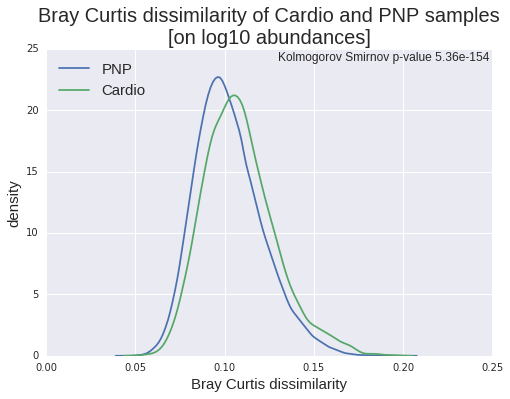

In [2013]:
# pnp_temp_values = pnp_MPA_log_BC_res.copy().values.ravel()
# pnp_temp_values = pnp_temp_values[pnp_temp_values!=0]
# cardio_temp_values = Cardio_MPA_log_BC_res.copy().values.ravel()
# cardio_temp_values = cardio_temp_values[cardio_temp_values!=0]

pnp_temp_values = joined_MPA_log_BC_res.iloc[:pnp_fd_cnid.shape[0], :pnp_fd_cnid.shape[0]].values.ravel()
pnp_temp_values = pnp_temp_values[pnp_temp_values!=0]
cardio_temp_values = joined_MPA_log_BC_res.iloc[pnp_fd_cnid.shape[0]:, pnp_fd_cnid.shape[0]:].values.ravel()
cardio_temp_values = cardio_temp_values[cardio_temp_values!=0]

sns.distplot(pnp_temp_values, hist=False, label='PNP')
sns.distplot(cardio_temp_values, hist=False, label='Cardio')
plt.xlabel('Bray Curtis dissimilarity', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.title('Bray Curtis dissimilarity of Cardio and PNP samples\n[on log10 abundances]', fontsize=20)
plt.legend(loc='upper left', fontsize=15)

# bc_tt = ttest_ind(pnp_MPA_BC_res.values.ravel(), Cardio_MPA_BC_res.values.ravel())
# bc_mw = directed_mannwhitneyu(pnp_MPA_BC_res.values.ravel(), Cardio_MPA_BC_res.values.ravel())
bc_ks = ks_2samp(pnp_temp_values, cardio_temp_values)

plt.text(0.13, 24, "Kolmogorov Smirnov p-value " + '%s' % float('%.3g' % bc_ks[1]))
plt.savefig('figs/BrayCurtis_MPA_log10.png')
plt.show()

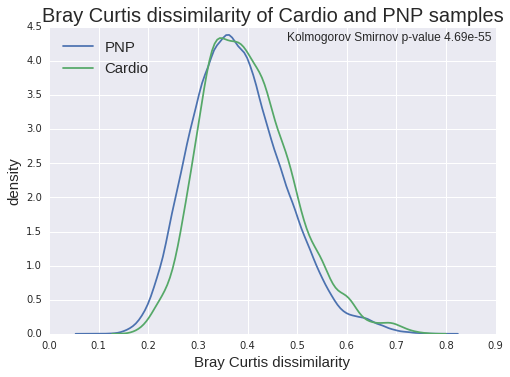

In [2014]:
# pnp_temp_values = pnp_MPA_BC_res.copy().values.ravel()
# pnp_temp_values = pnp_temp_values[pnp_temp_values!=0]
# cardio_temp_values = Cardio_MPA_BC_res.copy().values.ravel()
# cardio_temp_values = cardio_temp_values[cardio_temp_values!=0]

pnp_temp_values = joined_MPA_BC_res.iloc[:pnp_fd_cnid.shape[0], :pnp_fd_cnid.shape[0]].values.ravel()
pnp_temp_values = pnp_temp_values[pnp_temp_values!=0]
cardio_temp_values = joined_MPA_BC_res.iloc[pnp_fd_cnid.shape[0]:, pnp_fd_cnid.shape[0]:].values.ravel()
cardio_temp_values = cardio_temp_values[cardio_temp_values!=0]

sns.distplot(pnp_temp_values, hist=False, label='PNP')
sns.distplot(cardio_temp_values, hist=False, label='Cardio')
plt.xlabel('Bray Curtis dissimilarity', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.title('Bray Curtis dissimilarity of Cardio and PNP samples', fontsize=20)
plt.legend(loc='upper left', fontsize=15)

# bc_tt = ttest_ind(pnp_MPA_BC_res.values.ravel(), Cardio_MPA_BC_res.values.ravel())
# bc_mw = directed_mannwhitneyu(pnp_MPA_BC_res.values.ravel(), Cardio_MPA_BC_res.values.ravel())
bc_ks = ks_2samp(pnp_temp_values, cardio_temp_values)

plt.text(0.48, 4.3, "Kolmogorov Smirnov p-value " + '%s' % float('%.3g' % bc_ks[1]))
plt.savefig('figs/BrayCurtis_MPA.png')
plt.show()

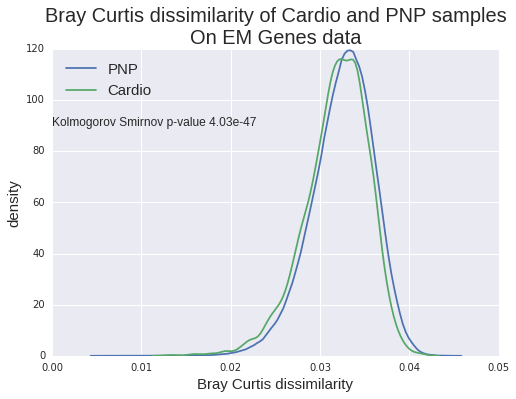

In [2015]:
pnp_temp_values = joined_em_log_BC_res.iloc[:pnp_fd_cnid.shape[0]-1, :pnp_fd_cnid.shape[0]-1].values.ravel()
pnp_temp_values = pnp_temp_values[pnp_temp_values!=0]
cardio_temp_values = joined_em_log_BC_res.iloc[pnp_fd_cnid.shape[0]-1:, pnp_fd_cnid.shape[0]-1:].values.ravel()
cardio_temp_values = cardio_temp_values[cardio_temp_values!=0]

sns.distplot(pnp_temp_values, hist=False, label='PNP')
sns.distplot(cardio_temp_values, hist=False, label='Cardio')
plt.xlabel('Bray Curtis dissimilarity', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.title('Bray Curtis dissimilarity of Cardio and PNP samples\nOn EM Genes data', fontsize=20)
plt.legend(loc='upper left', fontsize=15)

# bc_tt = ttest_ind(pnp_MPA_BC_res.values.ravel(), Cardio_MPA_BC_res.values.ravel())
# bc_mw = directed_mannwhitneyu(pnp_MPA_BC_res.values.ravel(), Cardio_MPA_BC_res.values.ravel())
bc_ks = ks_2samp(pnp_temp_values, cardio_temp_values)

plt.text(0, 90, "Kolmogorov Smirnov p-value " + '%s' % float('%.3g' % bc_ks[1]))
plt.savefig('figs/BrayCurtis_EMGenes_log.png')
plt.show()

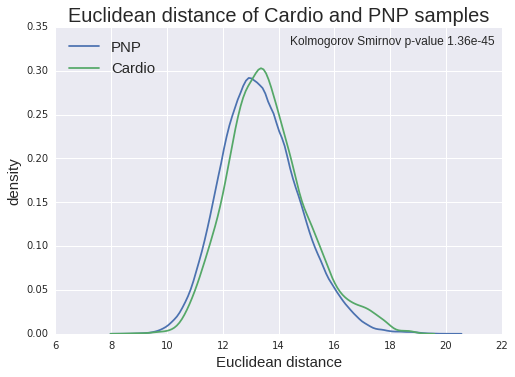

In [626]:
# pnp_temp_values = pnp_MPA_BinEuc_res.copy().values.ravel()
# pnp_temp_values = pnp_temp_values[pnp_temp_values!=0]
# cardio_temp_values = Cardio_MPA_BinEuc_res.copy().values.ravel()
# cardio_temp_values = cardio_temp_values[cardio_temp_values!=0]

# sns.distplot(pnp_temp_values, hist=False, label='PNP')
# sns.distplot(cardio_temp_values, hist=False, label='Cardio')
# plt.xlabel('Euclidean distance', fontsize=15)
# plt.ylabel('density', fontsize=15)
# plt.title('Euclidean distance of Cardio and PNP samples', fontsize=20)
# plt.legend(loc='upper left', fontsize=15)

# # ec_tt = ttest_ind(pnp_MPA_BinEuc_res.values.ravel(), Cardio_MPA_BinEuc_res.values.ravel())
# # ec_mw = directed_mannwhitneyu(pnp_MPA_BinEuc_res.values.ravel(), Cardio_MPA_BinEuc_res.values.ravel())
# ec_ks = ks_2samp(pnp_temp_values, cardio_temp_values)

# plt.text(14.4, 0.33, "Kolmogorov Smirnov p-value " + '%s' % float('%.3g' % ec_ks[1]))
# plt.savefig('Euclidean_MPA.png')
# plt.show()

### intergroup vs permuted

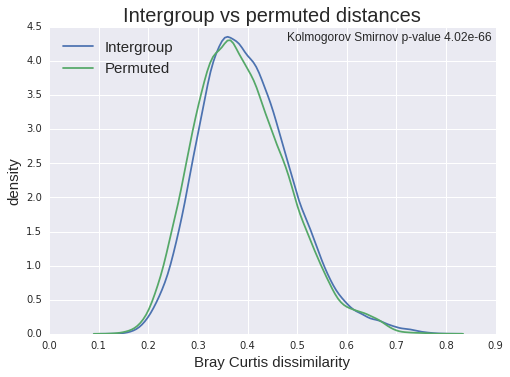

In [2016]:
outter_MPA_BC_values = joined_MPA_BC_res.iloc[0:pnp_fd_cnid.shape[0], pnp_fd_cnid.shape[0]:].values.ravel()
permuted_MPA_BC_values = joined_MPA_permuted_BC_res.iloc[0:pnp_fd_cnid.shape[0], pnp_fd_cnid.shape[0]:].values.ravel()


sns.distplot(outter_MPA_BC_values, hist=False, label='Intergroup')
sns.distplot(permuted_MPA_BC_values, hist=False, label='Permuted')
plt.xlabel('Bray Curtis dissimilarity', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.title('Intergroup vs permuted distances', fontsize=20)
plt.legend(loc='upper left', fontsize=15)

# # ec_tt = ttest_ind(pnp_MPA_BinEuc_res.values.ravel(), Cardio_MPA_BinEuc_res.values.ravel())
# # ec_mw = directed_mannwhitneyu(pnp_MPA_BinEuc_res.values.ravel(), Cardio_MPA_BinEuc_res.values.ravel())
io_ks = ks_2samp(permuted_MPA_BC_values, outter_MPA_BC_values)
# io_ks = ks_2samp(Cardio_MPA_BC_res.values.ravel(), outter_MPA_BC_values)

plt.text(0.48, 4.3, "Kolmogorov Smirnov p-value " + '%s' % float('%.3g' % io_ks[1]))
plt.savefig('figs/Intergroup_vs_permuted_BC_MPA.png')
plt.show()

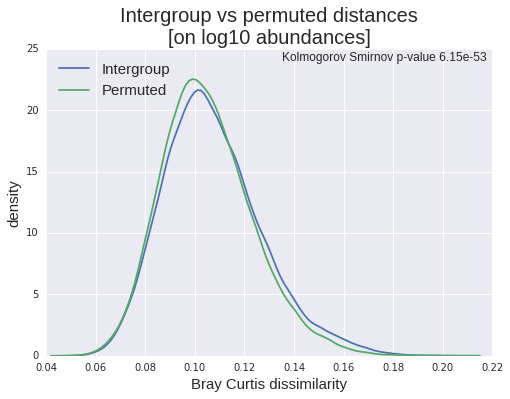

In [2017]:
outter_MPA_BC_values = joined_MPA_log_BC_res.iloc[0:pnp_fd_cnid.shape[0], pnp_fd_cnid.shape[0]:].values.ravel()
permuted_MPA_BC_values = joined_MPA_log_permuted_BC_res.iloc[0:pnp_fd_cnid.shape[0], pnp_fd_cnid.shape[0]:].values.ravel()
# pnp_temp_values = pnp_MPA_log_BC_res.copy().values.ravel()
# pnp_temp_values = pnp_temp_values[pnp_temp_values!=0]
# cardio_temp_values = Cardio_MPA_log_BC_res.copy().values.ravel()
# cardio_temp_values = cardio_temp_values[cardio_temp_values!=0]

# pnp_temp_values = joined_MPA_log_BC_res.iloc[:pnp_fd_cnid.shape[0], :pnp_fd_cnid.shape[0]].values.ravel()
# pnp_temp_values = pnp_temp_values[pnp_temp_values!=0]
# cardio_temp_values = joined_MPA_log_BC_res.iloc[pnp_fd_cnid.shape[0]:, pnp_fd_cnid.shape[0]:].values.ravel()
# cardio_temp_values = cardio_temp_values[cardio_temp_values!=0]

# sns.distplot(pnp_temp_values, hist=False, label='PNP')
# sns.distplot(cardio_temp_values, hist=False, label='Cardio')
sns.distplot(outter_MPA_BC_values, hist=False, label='Intergroup')
sns.distplot(permuted_MPA_BC_values, hist=False, label='Permuted')
plt.xlabel('Bray Curtis dissimilarity', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.title('Intergroup vs permuted distances\n[on log10 abundances]', fontsize=20)
plt.legend(loc='upper left', fontsize=15)

# # ec_tt = ttest_ind(pnp_MPA_BinEuc_res.values.ravel(), Cardio_MPA_BinEuc_res.values.ravel())
# # ec_mw = directed_mannwhitneyu(pnp_MPA_BinEuc_res.values.ravel(), Cardio_MPA_BinEuc_res.values.ravel())
io_ks = ks_2samp(permuted_MPA_BC_values, outter_MPA_BC_values)

plt.text(0.135, 24, "Kolmogorov Smirnov p-value " + '%s' % float('%.3g' % io_ks[1]))
plt.savefig('figs/Intergroup_vs_permuted_BC_MPA_log10.png')
plt.show()

In [2018]:
pnp_idx = [random.randint(0, pnp_fd_cnid.shape[0]-1) for x in range(10000)]
cardio_idx = [random.randint(0, cardio_fd_spid.shape[0]-1) for x in range(10000)]
outter_MPA_BinEuc_values = np.array([joined_MPA_BinEuc_res.iloc[pnp_idx[i], cardio_idx[i] + pnp_fd_cnid.shape[0]] for i in range(10000)])

pnp_temp_values = pnp_MPA_BinEuc_res.copy().values.ravel()
pnp_temp_values = pnp_temp_values[pnp_temp_values!=0]
cardio_temp_values = Cardio_MPA_BinEuc_res.copy().values.ravel()
cardio_temp_values = cardio_temp_values[cardio_temp_values!=0]

sns.distplot(pnp_temp_values, hist=False, label='PNP')
sns.distplot(cardio_temp_values, hist=False, label='Cardio')
sns.distplot(outter_MPA_BinEuc_values, hist=False, label='Mixed')
plt.xlabel('Euclidean distance', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.title('Inner vs outter distances', fontsize=20)
plt.legend(loc='upper left', fontsize=15)

# # ec_tt = ttest_ind(pnp_MPA_BinEuc_res.values.ravel(), Cardio_MPA_BinEuc_res.values.ravel())
# # ec_mw = directed_mannwhitneyu(pnp_MPA_BinEuc_res.values.ravel(), Cardio_MPA_BinEuc_res.values.ravel())
io_ks = ks_2samp(np.concatenate((pnp_temp_values, cardio_temp_values)), outter_MPA_BinEuc_values)
# io_ks = ks_2samp(Cardio_MPA_BC_res.values.ravel(), outter_MPA_BC_values)

plt.text(14.5, 0.33, "Kolmogorov Smirnov p-value " + '%s' % float('%.3g' % io_ks[1]))
plt.savefig('figs/Inner_vs_Outter_BinEuc_MPA.png')
plt.show()

/usr/wisdom/python/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/wisdom/python/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/wisdom/python/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


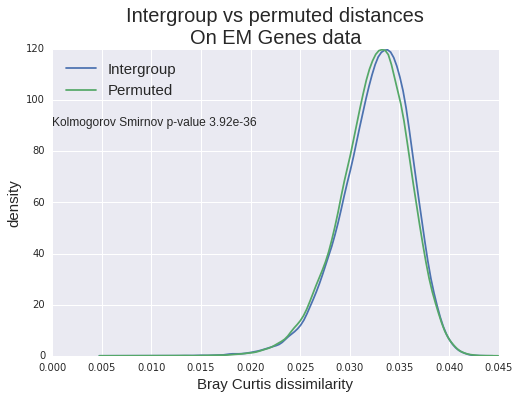

In [2019]:
outter_MPA_BC_values = joined_em_log_BC_res.iloc[0:pnp_fd_cnid.shape[0]-1, pnp_fd_cnid.shape[0]-1:].values.ravel()
permuted_MPA_BC_values = joined_em_log_permuted_BC_res.iloc[0:pnp_fd_cnid.shape[0]-1, pnp_fd_cnid.shape[0]-1:].values.ravel()


sns.distplot(outter_MPA_BC_values, hist=False, label='Intergroup')
sns.distplot(permuted_MPA_BC_values, hist=False, label='Permuted')
plt.xlabel('Bray Curtis dissimilarity', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.title('Intergroup vs permuted distances\nOn EM Genes data', fontsize=20)
plt.legend(loc='upper left', fontsize=15)

# # ec_tt = ttest_ind(pnp_MPA_BinEuc_res.values.ravel(), Cardio_MPA_BinEuc_res.values.ravel())
# # ec_mw = directed_mannwhitneyu(pnp_MPA_BinEuc_res.values.ravel(), Cardio_MPA_BinEuc_res.values.ravel())
io_ks = ks_2samp(permuted_MPA_BC_values, outter_MPA_BC_values)
# io_ks = ks_2samp(Cardio_MPA_BC_res.values.ravel(), outter_MPA_BC_values)

plt.text(0, 90, "Kolmogorov Smirnov p-value " + '%s' % float('%.3g' % io_ks[1]))
plt.savefig('figs/Intergroup_vs_permuted_BC_EMGenes.png')
plt.show()

## PCoA

### genomes

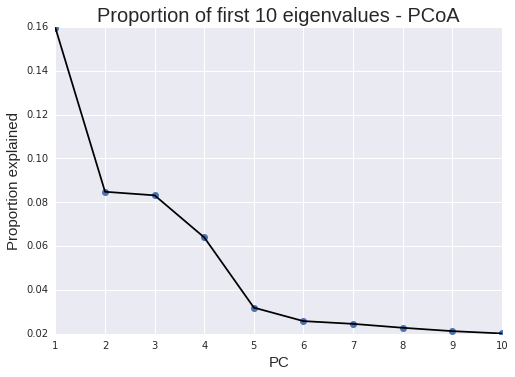

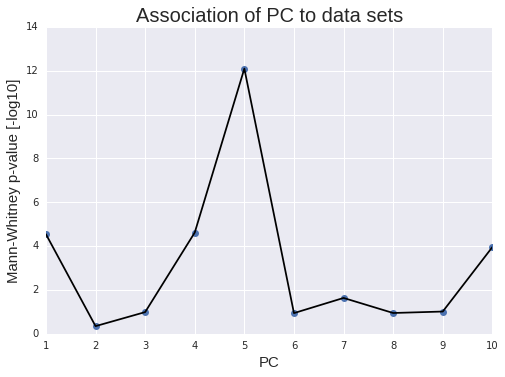

In [2022]:
if not os.path.exists('figs/PCoA_figs/'): os.makedirs('figs/PCoA_figs/') 
if not os.path.exists('figs/PCoA_log_figs/'): os.makedirs('figs/PCoA_log_figs/')
# pcoa, pcoa_MPA_log_BC  = 'figs/PCoA_figs/',  joined_MPA_BC_res.copy()
pcoa, pcoa_MPA_log_BC = 'figs/PCoA_log_figs/', joined_MPA_log_BC_res.copy()

n_pnp = pnp_fd_cnid.shape[0]
d = DistanceMatrix(pcoa_MPA_log_BC.values, pcoa_MPA_log_BC.index)
a = PCoA(d)

a_scores = a.scores()

plt.plot(range(1,11), a_scores.proportion_explained[0:10], 'o',  range(1,11), a_scores.proportion_explained[0:10], 'k')
plt.xlabel('PC', fontsize=15)
plt.ylabel('Proportion explained', fontsize=15)
plt.title('Proportion of first 10 eigenvalues - PCoA', fontsize=20)
plt.savefig(pcoa + 'proportion_explained_10.png')
plt.show()

mw_p = []
for i in range(10):
    mw_p.append(directed_mannwhitneyu(a_scores.site[0:n_pnp,i], a_scores.site[n_pnp:,i])[1])
mw_p= -np.log10(np.array(mw_p))
plt.plot(range(1,11), mw_p, 'o',  range(1,11), mw_p, 'k')
plt.xlabel('PC', fontsize=15)
plt.ylabel('Mann-Whitney p-value [-log10]', fontsize=15)
plt.title('Association of PC to data sets', fontsize=20)
plt.savefig(pcoa + 'mann_whitney-pc.png')
plt.show()

for i in range(1,10):
    plt.scatter(a_scores.site[:n_pnp,0], a_scores.site[:n_pnp,i], color='red' , alpha=0.6, label='PNP')
    plt.scatter(a_scores.site[n_pnp:,0], a_scores.site[n_pnp:,i], color='black', alpha=0.6, label='Cardio')
    pc1_per = '%s' % float('%.3g' % a_scores.proportion_explained[0])
    pc2_per = '%s' % float('%.3g' % a_scores.proportion_explained[i])
    plt.xlabel('PC1 - ' + pc1_per, fontsize=15)
    plt.ylabel('PC' + str(i+1) + ' - ' + pc2_per, fontsize=15)
    plt.title('PCoA', fontsize=20)
    plt.legend(loc='upper left', fontsize=15)
    plt.savefig(pcoa + '/PC1-PC' + str(i+1) + '.png')
    plt.clf()
#     plt.show()
plt.scatter(a_scores.site[:n_pnp,9], a_scores.site[:n_pnp,2], color='red' , alpha=0.6, label='PNP')
plt.scatter(a_scores.site[n_pnp:,9], a_scores.site[n_pnp:,2], color='black', alpha=0.6, label='Cardio')
pc1_per = '%s' % float('%.3g' % a_scores.proportion_explained[9])
pc2_per = '%s' % float('%.3g' % a_scores.proportion_explained[2])
plt.xlabel('PC10 - ' + pc1_per, fontsize=15)
plt.ylabel('PC3 - ' + pc2_per, fontsize=15)
plt.title('PCoA', fontsize=20)
plt.legend(loc='upper left', fontsize=15)
plt.savefig(pcoa + '/PC10-PC3.png')
plt.clf()
plt.scatter(a_scores.site[:n_pnp,9], a_scores.site[:n_pnp,6], color='red' , alpha=0.6, label='PNP')
plt.scatter(a_scores.site[n_pnp:,9], a_scores.site[n_pnp:,6], color='black', alpha=0.6, label='Cardio')
# mean_c_x,mean_c_y = np.mean(a_scores.site[pnp_fd_cnid.shape[0]:,9]), np.mean(a_scores.site[pnp_fd_cnid.shape[0]:,6])
# mean_p_x,mean_p_y = np.mean(a_scores.site[:pnp_fd_cnid.shape[0],9]), np.mean(a_scores.site[:pnp_fd_cnid.shape[0],6])
# plt.scatter(mean_c_x, mean_c_y, color="green", s=50)
# plt.scatter(mean_p_x, mean_p_y, color="purple", s=50)
pc1_per = '%s' % float('%.3g' % a_scores.proportion_explained[9])
pc2_per = '%s' % float('%.3g' % a_scores.proportion_explained[6])
plt.xlabel('PC10 - ' + pc1_per, fontsize=15)
plt.ylabel('PC7 - ' + pc2_per, fontsize=15)
plt.title('PCoA', fontsize=20)
plt.legend(loc='upper left', fontsize=15)
plt.savefig(pcoa + '/PC10-PC7.png')
plt.clf()
# plt.show()
# for i in range(20):
#     print i
#     print directed_mannwhitneyu(a_scores.site[0:659,i], a_scores.site[659:,i])


In [1636]:
n_pnp = pnp_fd_cnid.shape[0]
n_cardio = cardio_fd_spid.shape[0]
X = a_scores.site
Y = np.array([0]* n_pnp + [1]*n_cardio)
Utils.Write('PCoA_sites_MPA_log_X.dat', X)
Utils.Write('PCoA_sites_MPA_log_Y.dat', Y)

### genes

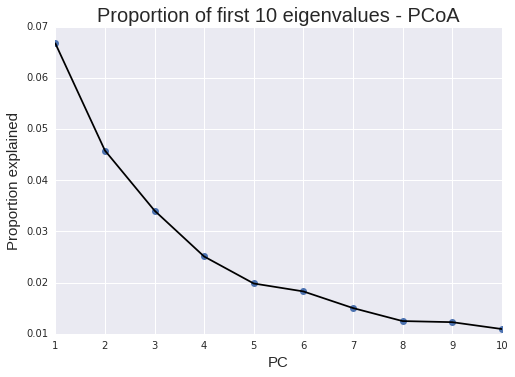

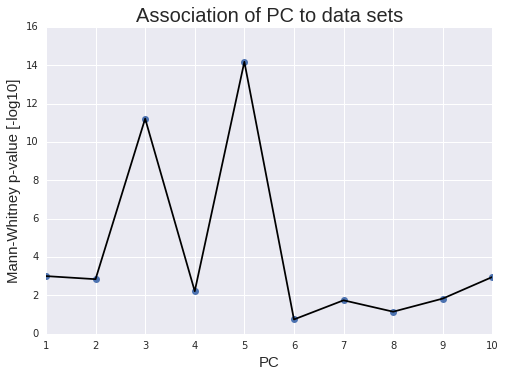

In [2026]:
# if not os.path.exists('figs/PCoA_EMGenes_figs/'): os.makedirs('figs/PCoA_EMGenes_figs/') 
if not os.path.exists('figs/PCoA_EMGenes_log_figs/'): os.makedirs('figs/PCoA_EMGenes_log_figs/')
# pcoa, pcoa_MPA_log_BC  = 'figs/PCoA_EMGenes_figs/',  joined_MPA_BC_res.copy()
pcoa, pcoa_em_log_BC = 'figs/PCoA_EMGenes_log_figs/', joined_em_log_BC_res.copy()

n_pnp = pnp_fd_cnid.shape[0] - 1

d = DistanceMatrix(pcoa_em_log_BC.values, pcoa_em_log_BC.index)
a = PCoA(d)

a_scores = a.scores()

plt.plot(range(1,11), a_scores.proportion_explained[0:10], 'o',  range(1,11), a_scores.proportion_explained[0:10], 'k')
plt.xlabel('PC', fontsize=15)
plt.ylabel('Proportion explained', fontsize=15)
plt.title('Proportion of first 10 eigenvalues - PCoA', fontsize=20)
plt.savefig(pcoa + 'proportion_explained_10.png')
plt.show()

mw_p = []
for i in range(10):
    mw_p.append(directed_mannwhitneyu(a_scores.site[0:n_pnp,i], a_scores.site[n_pnp:,i])[1])
mw_p= -np.log10(np.array(mw_p))
plt.plot(range(1,11), mw_p, 'o',  range(1,11), mw_p, 'k')
plt.xlabel('PC', fontsize=15)
plt.ylabel('Mann-Whitney p-value [-log10]', fontsize=15)
plt.title('Association of PC to data sets', fontsize=20)
plt.savefig(pcoa + 'mann_whitney-pc.png')
plt.show()

for i in range(1,10):
    plt.scatter(a_scores.site[:n_pnp,0], a_scores.site[:n_pnp,i], color='red' , alpha=0.6, label='PNP')
    plt.scatter(a_scores.site[n_pnp:,0], a_scores.site[n_pnp:,i], color='black', alpha=0.6, label='Cardio')
    pc1_per = '%s' % float('%.3g' % a_scores.proportion_explained[0])
    pc2_per = '%s' % float('%.3g' % a_scores.proportion_explained[i])
    plt.xlabel('PC1 - ' + pc1_per, fontsize=15)
    plt.ylabel('PC' + str(i+1) + ' - ' + pc2_per, fontsize=15)
    plt.title('PCoA', fontsize=20)
    plt.legend(loc='upper left', fontsize=15)
    plt.savefig(pcoa + '/PC1-PC' + str(i+1) + '.png')
    plt.clf()
#     plt.show()
plt.scatter(a_scores.site[:n_pnp,4], a_scores.site[:n_pnp,2], color='red' , alpha=0.6, label='PNP')
plt.scatter(a_scores.site[n_pnp:,4], a_scores.site[n_pnp:,2], color='black', alpha=0.6, label='Cardio')
pc1_per = '%s' % float('%.3g' % a_scores.proportion_explained[4])
pc2_per = '%s' % float('%.3g' % a_scores.proportion_explained[2])
plt.xlabel('PC5 - ' + pc1_per, fontsize=15)
plt.ylabel('PC3 - ' + pc2_per, fontsize=15)
plt.title('PCoA', fontsize=20)
plt.legend(loc='upper left', fontsize=15)
plt.savefig(pcoa + '/PC5-PC3.png')
plt.clf()
# plt.scatter(a_scores.site[:n_pnp,9], a_scores.site[:n_pnp,6], color='red' , alpha=0.6, label='PNP')
# plt.scatter(a_scores.site[n_pnp:,9], a_scores.site[n_pnp:,6], color='black', alpha=0.6, label='Cardio')
# pc1_per = '%s' % float('%.3g' % a_scores.proportion_explained[9])
# pc2_per = '%s' % float('%.3g' % a_scores.proportion_explained[6])
# plt.xlabel('PC10 - ' + pc1_per, fontsize=15)
# plt.ylabel('PC7 - ' + pc2_per, fontsize=15)
# plt.title('PCoA', fontsize=20)
# plt.legend(loc='upper left', fontsize=15)
# plt.savefig(pcoa + '/PC10-PC7.png')
# plt.clf()
# plt.show()
# for i in range(20):
#     print i
#     print directed_mannwhitneyu(a_scores.site[0:659,i], a_scores.site[659:,i])


In [1842]:
n_pnp = pnp_fd_cnid.shape[0] - 1
n_cardio = cardio_fd_spid.shape[0]
X = a_scores.site
Y = np.array([0]* n_pnp + [1]*n_cardio)
Utils.Write('PCoA_sites_EMGenes_log_X.dat', X)
Utils.Write('PCoA_sites_EMGenes_Y.dat', Y)

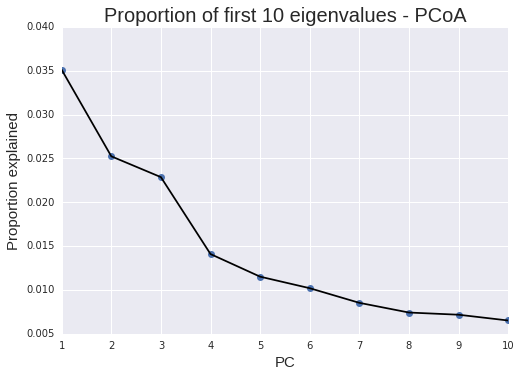

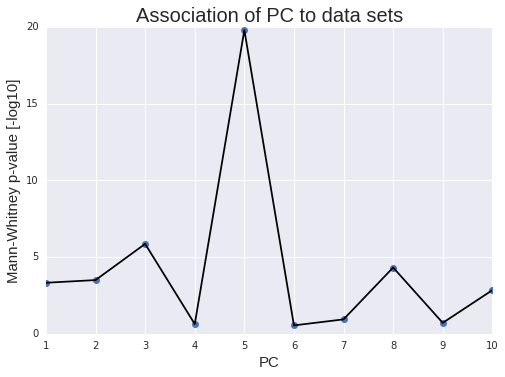

In [2027]:
if not os.path.exists('figs/PCoA_EMGenes_binary_figs/'): os.makedirs('figs/PCoA_EMGenes_binary_figs/')
pcoa, pcoa_em_binary = 'figs/PCoA_EMGenes_binary_figs/', joined_em_bin_Euc_res.copy()

n_pnp = pnp_fd_cnid.shape[0] - 1

d = DistanceMatrix(pcoa_em_binary.values, pcoa_em_binary.index)
a = PCoA(d)

a_scores = a.scores()

plt.plot(range(1,11), a_scores.proportion_explained[0:10], 'o',  range(1,11), a_scores.proportion_explained[0:10], 'k')
plt.xlabel('PC', fontsize=15)
plt.ylabel('Proportion explained', fontsize=15)
plt.title('Proportion of first 10 eigenvalues - PCoA', fontsize=20)
plt.savefig(pcoa + 'proportion_explained_10.png')
plt.show()

mw_p = []
for i in range(10):
    mw_p.append(directed_mannwhitneyu(a_scores.site[0:n_pnp,i], a_scores.site[n_pnp:,i])[1])
mw_p= -np.log10(np.array(mw_p))
plt.plot(range(1,11), mw_p, 'o',  range(1,11), mw_p, 'k')
plt.xlabel('PC', fontsize=15)
plt.ylabel('Mann-Whitney p-value [-log10]', fontsize=15)
plt.title('Association of PC to data sets', fontsize=20)
plt.savefig(pcoa + 'mann_whitney-pc.png')
plt.show()

for i in range(1,10):
    plt.scatter(a_scores.site[:n_pnp,0], a_scores.site[:n_pnp,i], color='red' , alpha=0.6, label='PNP')
    plt.scatter(a_scores.site[n_pnp:,0], a_scores.site[n_pnp:,i], color='black', alpha=0.6, label='Cardio')
    pc1_per = '%s' % float('%.3g' % a_scores.proportion_explained[0])
    pc2_per = '%s' % float('%.3g' % a_scores.proportion_explained[i])
    plt.xlabel('PC1 - ' + pc1_per, fontsize=15)
    plt.ylabel('PC' + str(i+1) + ' - ' + pc2_per, fontsize=15)
    plt.title('PCoA', fontsize=20)
    plt.legend(loc='upper left', fontsize=15)
    plt.savefig(pcoa + '/PC1-PC' + str(i+1) + '.png')
    plt.clf()
#     plt.show()
plt.scatter(a_scores.site[:n_pnp,4], a_scores.site[:n_pnp,2], color='red' , alpha=0.6, label='PNP')
plt.scatter(a_scores.site[n_pnp:,4], a_scores.site[n_pnp:,2], color='black', alpha=0.6, label='Cardio')
pc1_per = '%s' % float('%.3g' % a_scores.proportion_explained[4])
pc2_per = '%s' % float('%.3g' % a_scores.proportion_explained[2])
plt.xlabel('PC5 - ' + pc1_per, fontsize=15)
plt.ylabel('PC3 - ' + pc2_per, fontsize=15)
plt.title('PCoA', fontsize=20)
plt.legend(loc='upper left', fontsize=15)
plt.savefig(pcoa + '/PC5-PC3.png')
plt.clf()
# plt.scatter(a_scores.site[:n_pnp,9], a_scores.site[:n_pnp,6], color='red' , alpha=0.6, label='PNP')
# plt.scatter(a_scores.site[n_pnp:,9], a_scores.site[n_pnp:,6], color='black', alpha=0.6, label='Cardio')
# pc1_per = '%s' % float('%.3g' % a_scores.proportion_explained[9])
# pc2_per = '%s' % float('%.3g' % a_scores.proportion_explained[6])
# plt.xlabel('PC10 - ' + pc1_per, fontsize=15)
# plt.ylabel('PC7 - ' + pc2_per, fontsize=15)
# plt.title('PCoA', fontsize=20)
# plt.legend(loc='upper left', fontsize=15)
# plt.savefig(pcoa + '/PC10-PC7.png')
# plt.clf()
# plt.show()
# for i in range(20):
#     print i
#     print directed_mannwhitneyu(a_scores.site[0:659,i], a_scores.site[659:,i])


In [1844]:
n_pnp = pnp_fd_cnid.shape[0] - 1
n_cardio = cardio_fd_spid.shape[0]
X = a_scores.site
Y = np.array([0]* n_pnp + [1]*n_cardio)
Utils.Write('PCoA_sites_EMGenes_bin_X.dat', X)
Utils.Write('PCoA_sites_EMGenes_Y.dat', Y)

## PCA

### genomes

### genes

## TSNE

### genomes

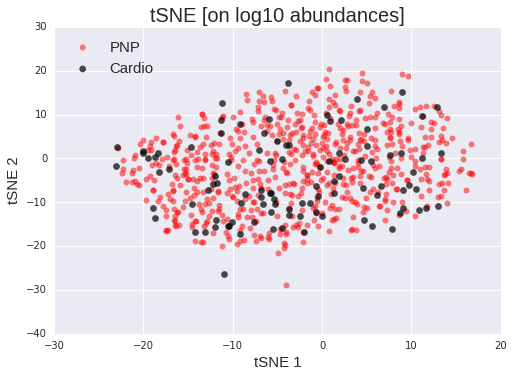

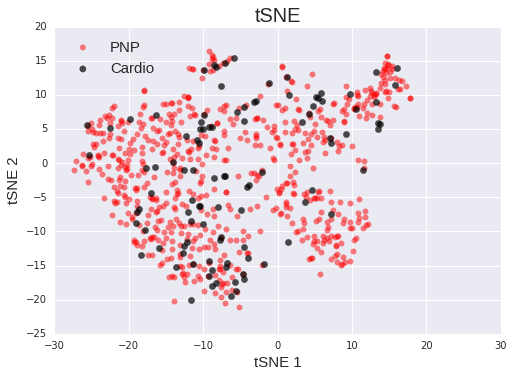

In [1202]:
n_pnp = pnp_fd_cnid.shape[0] 

joined_MPA_log_embedded = TSNE(n_components=2, perplexity=30, n_iter=5000).fit_transform(joined_MPA_log.T)

plt.scatter(joined_MPA_log_embedded[:n_pnp,0], joined_MPA_log_embedded[:n_pnp,1], color='red' , alpha=0.5, label='PNP', s=30)
plt.scatter(joined_MPA_log_embedded[n_pnp:,0], joined_MPA_log_embedded[n_pnp:,1], color='black', alpha=0.7, label='Cardio', s=40)

plt.xlabel('tSNE 1', fontsize=15)
plt.ylabel('tSNE 2', fontsize=15)
plt.title('tSNE [on log10 abundances]', fontsize=20)
plt.legend(loc='upper left', fontsize=15)
plt.savefig('figs/tSNE_MPA_log.png')
plt.show()
plt.clf()

joined_MPA_log_embedded = TSNE(n_components=2, perplexity=30, n_iter=5000).fit_transform(joined_MPA.T)

plt.scatter(joined_MPA_log_embedded[:n_pnp,0], joined_MPA_log_embedded[:n_pnp,1], color='red' , alpha=0.5, label='PNP', s=30)
plt.scatter(joined_MPA_log_embedded[n_pnp:,0], joined_MPA_log_embedded[n_pnp:,1], color='black', alpha=0.7, label='Cardio', s=40)

plt.xlabel('tSNE 1', fontsize=15)
plt.ylabel('tSNE 2', fontsize=15)
plt.title('tSNE', fontsize=20)
plt.legend(loc='upper left', fontsize=15)
plt.savefig('figs/tSNE_MPA.png')
plt.show()
plt.clf()

### genes

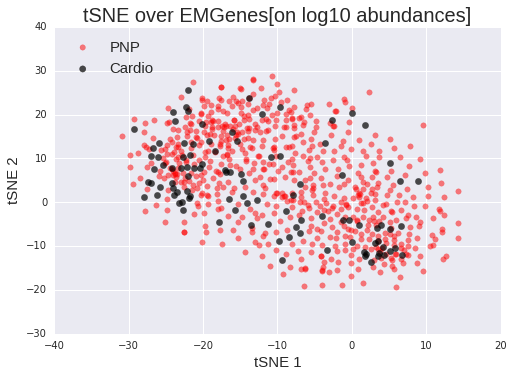

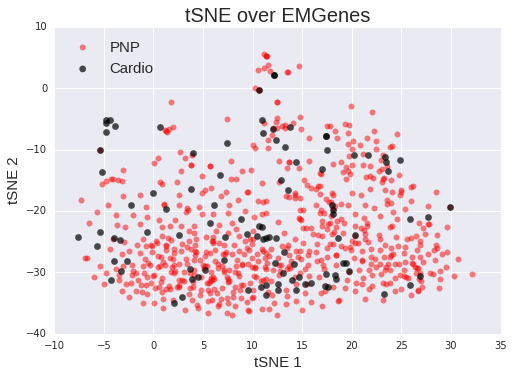

In [1414]:
n_pnp = pnp_fd_cnid.shape[0] - 1

joined_em_log_embedded = TSNE(n_components=2, perplexity=30, n_iter=5000).fit_transform(joined_em_log.T)

plt.scatter(joined_em_log_embedded[:n_pnp,0], joined_em_log_embedded[:n_pnp,1], color='red' , alpha=0.5, label='PNP', s=30)
plt.scatter(joined_em_log_embedded[n_pnp:,0], joined_em_log_embedded[n_pnp:,1], color='black', alpha=0.7, label='Cardio', s=40)

plt.xlabel('tSNE 1', fontsize=15)
plt.ylabel('tSNE 2', fontsize=15)
plt.title('tSNE over EMGenes[on log10 abundances]', fontsize=20)
plt.legend(loc='upper left', fontsize=15)
plt.savefig('figs/tSNE_em_log.png')
plt.show()
plt.clf()

joined_em_embedded = TSNE(n_components=2, perplexity=30, n_iter=5000).fit_transform(joined_em.T)

plt.scatter(joined_em_embedded[:n_pnp,0], joined_em_embedded[:n_pnp,1], color='red' , alpha=0.5, label='PNP', s=30)
plt.scatter(joined_em_embedded[n_pnp:,0], joined_em_embedded[n_pnp:,1], color='black', alpha=0.7, label='Cardio', s=40)

plt.xlabel('tSNE 1', fontsize=15)
plt.ylabel('tSNE 2', fontsize=15)
plt.title('tSNE over EMGenes', fontsize=20)
plt.legend(loc='upper left', fontsize=15)
plt.savefig('figs/tSNE_em.png')
plt.show()
plt.clf()

## Mantel

### genomes

In [1214]:
n_pnp = pnp_fd_cnid.shape[0]
n_cardio = cardio_fd_spid.shape[0]

data_distances = np.ones((n_pnp + n_cardio, n_pnp + n_cardio))
data_distances[:n_pnp, :n_pnp] = data_distances[n_pnp:, n_pnp:] = 0

1


(0.099507593532593447, 0.00014999999999999999, 3.9277480055537239)

In [1279]:
# mantel_test(data_distances, joined_MPA_log_BC_res.values, perms=20000, method='spearman', tail='upper')

mantel_results = []
print "Mantel test for MPA (Bray-Curtis on log data) and identity (Euclidean) using pearson:"
print mantel_test(data_distances, joined_MPA_log_BC_res.values, perms=20000, method='pearson', tail='upper')
print "Mantel test for MPA (Bray-Curtis on log data) and identity (Euclidean) using spearman:"
print mantel_test(data_distances, joined_MPA_log_BC_res.values, perms=20000, method='spearman', tail='upper')
print "Mantel test for MPA (Bray-Curtis) and identity (Euclidean) using pearson:"
print mantel_test(data_distances, joined_MPA_BC_res.values, perms=20000, method='pearson', tail='upper')
print "Mantel test for MPA (Bray-Curtis) and identity (Euclidean) using spearman:"
print mantel_test(data_distances, joined_MPA_BC_res.values, perms=20000, method='spearman', tail='upper')

Mantel test for MPA (Bray-Curtis on log data) and identity (Euclidean) using pearson:
1
(0.10248816897570209, 0.00020000000000000001, 3.9472404772483038)
Mantel test for MPA (Bray-Curtis on log data) and identity (Euclidean) using spearman:
1
(0.099507593532593447, 5.0000000000000002e-05, 3.9205315270987349)
Mantel test for MPA (Bray-Curtis) and identity (Euclidean) using pearson:
1
(0.07839937998979285, 0.00080000000000000004, 3.3289258550246772)
Mantel test for MPA (Bray-Curtis) and identity (Euclidean) using spearman:
1
(0.076776565891920931, 0.00069999999999999999, 3.3986753001453476)


In [1280]:
print "Mantel test for MPA (Bray-Curtis on log data) and identity (Euclidean) using spearman:"
print mantel_test(data_distances, joined_MPA_log_BC_res.values, perms=1000000, method='spearman', tail='upper')

Mantel test for MPA (Bray-Curtis on log data) and identity (Euclidean) using spearman:
1
100001
200001
300001
400001
500001
600001
700001
800001
900001
(0.099507593532593447, 9.7e-05, 3.9511611544013938)


### genes

In [92]:
n_pnp = pnp_fd_cnid.shape[0] - 1
n_cardio = cardio_fd_spid.shape[0]
data_distances = np.ones((n_pnp + n_cardio, n_pnp + n_cardio))
data_distances[:n_pnp, :n_pnp] = data_distances[n_pnp:, n_pnp:] = 0

In [1397]:
print "Mantel test for EM (Bray-Curtis on log data) and identity (Euclidean) using pearson:"
print mantel_test(data_distances, joined_em_log_BC_res.values, perms=100000, method='pearson', tail='upper')
print "Mantel test for EM (Bray-Curtis on log data) and identity (Euclidean) using spearman:"
print mantel_test(data_distances, joined_em_log_BC_res.values, perms=100000, method='spearman', tail='upper')
# print "Mantel test for MPA (Bray-Curtis) and identity (Euclidean) using pearson:"
# print mantel_test(data_distances, joined_MPA_BC_res.values, perms=20000, method='pearson', tail='upper')
# print "Mantel test for MPA (Bray-Curtis) and identity (Euclidean) using spearman:"
# print mantel_test(data_distances, joined_MPA_BC_res.values, perms=20000, method='spearman', tail='upper')

Mantel test for EM (Bray-Curtis on log data) and identity (Euclidean) using pearson:
1
(0.015677553744010669, 0.27205000000000001, 0.60703848351130818)
Mantel test for EM (Bray-Curtis on log data) and identity (Euclidean) using spearman:
1
(0.020092920951708882, 0.21312, 0.7932541580515311)


In [1812]:
print "Mantel test for EM (Bray-Curtis on log data) and identity (Euclidean) using pearson:"
print mantel_test(data_distances, joined_em_bin_Euc_res.values, perms=10000, method='pearson', tail='upper')
print "Mantel test for EM (Bray-Curtis on log data) and identity (Euclidean) using spearman:"
print mantel_test(data_distances, joined_em_bin_Euc_res.values, perms=10000, method='spearman', tail='upper')

Mantel test for EM (Bray-Curtis on log data) and identity (Euclidean) using pearson:
1
(0.014456876425217906, 0.28449999999999998, 0.57190639901295748)
Mantel test for EM (Bray-Curtis on log data) and identity (Euclidean) using spearman:
1
(0.018576587359952497, 0.22450000000000001, 0.74522651139892748)


## Predictor

### genomes

In [1711]:
temp_file = Utils.Load('predictions_MPA_log/final_predictions.dat')
temp_file.sort_values('auc').tail(1)

,auc,k_fold,learning_rate,max_depth,max_features,min_samples_split,n_estimators,n_pcs,random_state,samples_weight,subsample
9423,0.888835,12,0.02,3,0.4,3,5500,70,7,3,0.3


In [1990]:
params = {'n_estimators':5500, 'learning_rate':0.02, 'max_depth':3, 'random_state':7, 'subsample': 0.3, 'max_features':0.4, 'min_samples_split':3}
n_PCS = 70

n_pnp = pnp_fd_cnid.shape[0]
n_cardio = cardio_fd_spid.shape[0]
# d = DistanceMatrix(pcoa_MPA_log_BC.values, pcoa_MPA_log_BC.index)
# a = PCoA(d)

# a_scores = a.scores()

# X = a_scores.site[:,:n_PCS]
# Y = np.array([0]* n_pnp + [1]*n_cardio)

# groups = np.array(range(len(X)))
# group_kfold = GroupKFold(n_splits=12)

# final_pred = np.array([])
# final_test =  np.array([])

# i = 0
# for train_index, test_index in group_kfold.split(X, Y, groups):
#     print i
#     i += 1
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = Y[train_index], Y[test_index]
#     est = GradientBoostingClassifier(**params).fit(X_train, y_train, sample_weight=(y_train*3)+1)
#     vals = est.predict_proba(X_test)
#     final_pred = np.concatenate((final_pred, vals[:,1]))
#     final_test = np.concatenate((final_test, y_test))

    
X = joined_MPA_log.copy()
X = X.values.T
# X = a_scores.site[:,:n_PCS]
Y = np.array([0]* n_pnp + [1]*n_cardio)

groups = np.array(range(len(X)))
group_kfold = GroupKFold(n_splits=12)

final_pred = np.array([])
final_test =  np.array([])

i = 0
for train_index, test_index in group_kfold.split(X, Y, groups):
    print i
    i += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    pca = PCA(n_components=185)
    X_train = pca.fit_transform(X_train)
    print "done fitting"
    X_test = pca.transform(X_test)
    print "done projecting"
#     d = DistanceMatrix(X_train.values, X_train.index)
#     a = PCoA(d)
#     a_scores = a.scores()
#     X_train = a_scores.site[:,:n_PCS]
#     X_Test = 
    
    est = GradientBoostingClassifier(**params).fit(X_train, y_train, sample_weight=(y_train*3)+1)
    vals = est.predict_proba(X_test)
    final_pred = np.concatenate((final_pred, vals[:,1]))
    final_test = np.concatenate((final_test, y_test))

0
done fitting
done projecting
1
done fitting
done projecting
2
done fitting
done projecting
3
done fitting
done projecting
4
done fitting
done projecting
5
done fitting
done projecting
6
done fitting
done projecting
7
done fitting
done projecting
8
done fitting
done projecting
9
done fitting
done projecting
10
done fitting
done projecting
11
done fitting
done projecting


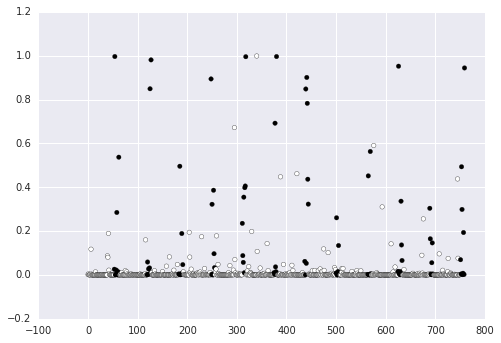

In [1991]:
plt.scatter(range(len(final_pred)), final_pred, c=final_test)
plt.show()

In [1993]:
fpr, tpr, thresholds = metrics.roc_curve(final_test+1, final_pred, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.82906894634835249

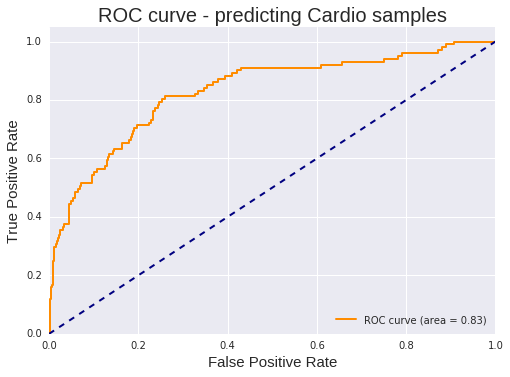

In [1994]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve - predicting Cardio samples', fontsize=20)
plt.legend(loc="lower right")
plt.savefig('figs/PCA_MPA_log_ROC.png')
plt.show()

### genes

In [1855]:
random_genes_preds = Utils.Load('predictions_EMGenes_log/final_predictions.dat')
random_genes_preds.sort_values('auc').tail()

,auc,k_fold,learning_rate,max_depth,max_features,min_samples_split,n_estimators,n_pcs,random_state,samples_weight,subsample
1856,0.884483,8.0,0.0075,3.0,0.5,6.0,3000.0,125.0,8.0,3.0,0.6
2595,0.885100,8.0,0.0020,2.0,0.5,4.0,9500.0,140.0,5.0,7.0,0.3
1575,0.885115,8.0,0.0200,3.0,0.5,5.0,2000.0,140.0,0.0,3.0,0.4
3490,0.885401,8.0,0.0090,4.0,0.3,5.0,7000.0,135.0,3.0,5.0,0.4
6411,0.887041,8.0,0.0050,4.0,0.5,2.0,8500.0,135.0,3.0,6.0,0.3


In [1866]:
params = {'n_estimators':8500, 'learning_rate':0.005, 'max_depth':4, 'random_state':3, 'subsample': 0.3, 'max_features':0.5, 'min_samples_split':2}
n_PCS = 135

n_pnp = pnp_fd_cnid.shape[0] - 1
n_cardio = cardio_fd_spid.shape[0]
d = DistanceMatrix(pcoa_em_log_BC.values, pcoa_em_log_BC.index)

a = PCoA(d)

a_scores = a.scores()

X = a_scores.site[:,:n_PCS]
Y = np.array([0]* n_pnp + [1]*n_cardio)

groups = np.array(range(len(X)))
group_kfold = GroupKFold(n_splits=8)

final_pred = np.array([])
final_test =  np.array([])

i = 0
for train_index, test_index in group_kfold.split(X, Y, groups):
    print i
    i += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    est = GradientBoostingClassifier(**params).fit(X_train, y_train, sample_weight=(y_train*6)+1)
    vals = est.predict_proba(X_test)
    final_pred = np.concatenate((final_pred, vals[:,1]))
    final_test = np.concatenate((final_test, y_test))

0
1
2
3
4
5
6


KeyboardInterrupt: 

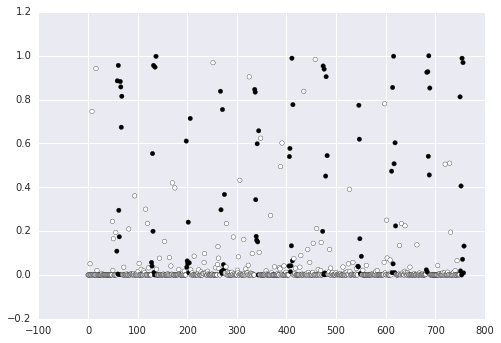

In [1862]:
plt.scatter(range(len(final_pred)), final_pred, c=final_test)
plt.show()

In [1863]:
fpr, tpr, thresholds = metrics.roc_curve(final_test+1, final_pred, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)

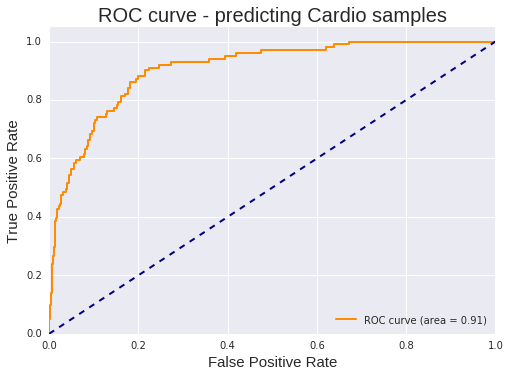

In [1864]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve - predicting Cardio samples', fontsize=20)
plt.legend(loc="lower right")
plt.savefig('figs/PCoA_EMGenes_log_figs/ROC.png')
plt.show()

In [1895]:
w = Utils.Load('predictions_EMGenes_bin/final_predictions.dat')
w.sort_values('auc').tail(5)

,auc,k_fold,learning_rate,max_depth,max_features,min_samples_split,n_estimators,n_pcs,random_state,samples_weight,subsample
4728,0.908995,11,0.0200,2,0.5,3,8500,160,2,3,0.3
4098,0.909447,15,0.0090,2,0.5,7,7000,180,6,3,0.2
4838,0.910635,15,0.0075,2,0.3,3,4000,155,6,4,0.2
4383,0.911899,15,0.0150,2,0.5,6,5500,160,4,3,0.3
1695,0.912772,11,0.0100,2,0.4,2,5000,175,3,4,0.2


In [1977]:
params = {'n_estimators':7500, 'learning_rate':0.0080, 'max_depth':2, 'random_state':6, 'subsample': 0.3, 'max_features':0.4, 'min_samples_split':7}
n_PCS = 185
n_pnp = pnp_fd_cnid.shape[0] - 1
n_cardio = cardio_fd_spid.shape[0]
# d = DistanceMatrix(pcoa_em_binary.values, pcoa_em_binary.index)
# a = PCoA(d)

# a_scores = a.scores()

# X = pcoa_em_binary.copy()
X = joined_em_binary.copy()
X = X.values.T
# X = a_scores.site[:,:n_PCS]
Y = np.array([0]* n_pnp + [1]*n_cardio)

groups = np.array(range(len(X)))
group_kfold = GroupKFold(n_splits=15)

final_pred = np.array([])
final_test =  np.array([])

i = 0
for train_index, test_index in group_kfold.split(X, Y, groups):
    print i
    i += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    pca = PCA(n_components=185)
    X_train = pca.fit_transform(X_train)
    print "done fitting"
    X_test = pca.transform(X_test)
    print "done projecting"
#     d = DistanceMatrix(X_train.values, X_train.index)
#     a = PCoA(d)
#     a_scores = a.scores()
#     X_train = a_scores.site[:,:n_PCS]
#     X_Test = 
    
    est = GradientBoostingClassifier(**params).fit(X_train, y_train, sample_weight=(y_train*2)+1)
    vals = est.predict_proba(X_test)
    final_pred = np.concatenate((final_pred, vals[:,1]))
    final_test = np.concatenate((final_test, y_test))

0
done fitting
done projecting
1
done fitting
done projecting
2
done fitting
done projecting
3
done fitting
done projecting
4
done fitting
done projecting
5
done fitting
done projecting
6
done fitting
done projecting
7
done fitting
done projecting
8
done fitting
done projecting
9
done fitting
done projecting
10
done fitting
done projecting
11
done fitting
done projecting
12
done fitting
done projecting
13
done fitting
done projecting
14
done fitting
done projecting


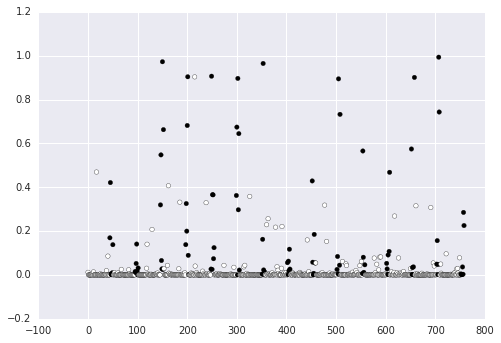

In [1979]:
plt.scatter(range(len(final_pred)), final_pred, c=final_test)
plt.show()

In [1980]:
fpr, tpr, thresholds = metrics.roc_curve(final_test+1, final_pred, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.89510668392067161

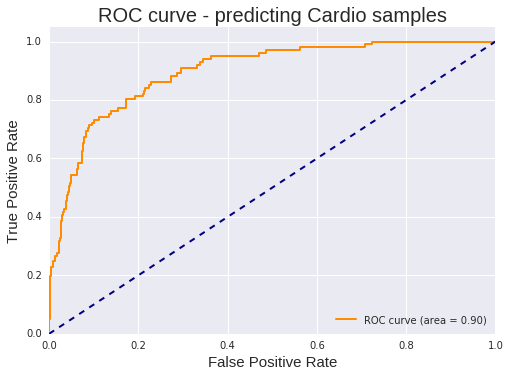

In [1989]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve - predicting Cardio samples', fontsize=20)
plt.legend(loc="lower right")
plt.savefig('figs/PCA_EMGenes_binary_ROC.png')
plt.show()

In [2007]:
w = Utils.Load('predictions_EMGenes_bin_PCA/final_predictions.dat')
w.sort_values('auc').tail(10)

,X,auc,dim_red_method,k_fold,learning_rate,max_depth,max_features,min_samples_split,n_estimators,n_pcs,random_state,samples_weight,subsample
1029,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.892910,PCA,25,0.0200,2,0.6,7,6500,150,6,4,0.2
299,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.893075,PCA,11,0.0075,3,0.4,7,7500,190,4,8,0.1
1050,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.894791,PCA,8,0.0100,3,0.6,5,4000,195,7,6,0.3
83,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.895302,PCA,10,0.0200,2,0.7,5,2500,185,9,6,0.2
41,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.895302,PCA,15,0.0075,2,0.5,7,8500,165,7,4,0.5
1143,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.896581,PCA,11,0.0150,4,0.3,2,5500,195,9,4,0.2
483,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.897168,PCA,9,0.0090,2,0.3,5,7000,160,3,3,0.4
373,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.898071,PCA,15,0.0050,2,0.7,6,5500,150,9,7,0.4
1070,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.898447,PCA,13,0.0100,2,0.5,5,5000,195,3,5,0.2
742,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.899847,PCA,15,0.0050,2,0.5,7,8000,185,8,4,0.4


## Shelley - Thomas project

In [ ]:
shelly_thomas = joined_em.copy()

shelly_thomas[shelly_thomas>1e-6] = 1
shelly_thomas[shelly_thomas<=1e-6] = 0

st_cardio = shelly_thomas.iloc[:,n_pnp:].copy()
st_pnp = shelly_thomas.iloc[:,:n_pnp].copy()

final_df = pd.DataFrame(index=st_cardio.index, columns=['delta', 'cardio_bigger', 'cardio_per', 'pnp_per', 'per_out_of_total'])

final_df['cardio_per'] = (st_cardio.sum(1) / n_cardio)
final_df['pnp_per'] = (st_pnp.sum(1) / n_pnp)

final_df['cardio_bigger'] = final_df['cardio_per'] > final_df['pnp_per']

final_df['per_out_of_total'] = (st_cardio.sum(1) + st_pnp.sum(1)) / (n_cardio + n_pnp)

final_df['delta'] = abs(final_df.cardio_per - final_df.pnp_per)

final_df.to_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Shelly_Thomas_df.csv')

In [ ]:
plt.hist(final_df.delta, bins=100)
# plt.xlim((0.1, 0.8))
# plt.ylim((0,20000))
plt.show()
# final_df.loc[(final_df.delta > 0.7),:]
# ((final_df.delta > 0.2) & (final_df.per_out_of_total > 0.2))
# (final_df.delta > 0.2).sum()
final_df.loc[((final_df.delta > 0.2) & (final_df.per_out_of_total > 0.2)),'cardio_bigger'].sum()

# Different Kits comparison

In [142]:
allseqproj = Utils.Load('/home/noamba/Analyses/AllSeqProjects/DFOut/ReadCountSpidDF.dat')
allseqproj = allseqproj.loc[-1]

In [143]:
allseqproj = allseqproj[allseqproj['PostSubSamp'] >= 10000000]
allseqproj.head()

,,RegistrantNumber,PostQC,RawReads,HGMapped,PostHGF,Exp,PostSubSamp,GeneSetMap_Count,GeneSetMap_Perc,FullGenomeMap_Count,FullGenomeMap_Perc
FD,PE/SE,,,,,,,,,,,
DT1606560028,SE,171,15170464,15269818,12071,15158393,2017-06-01-D2-Only,10000000.0,8436594,0.556563,3312786,0.218545
DT1606560030,SE,264,11672388,11729647,31043,11641345,2016-12-06-D2-Only,10000000.0,8393079,0.720972,2427446,0.208519
DT1606560035,SE,658,18718195,19741962,27150,18691045,2017-04-04-D2-Only,10000000.0,8237505,0.440719,2984070,0.159652
DT1606560045,SE,1061,12320267,12499258,2648,12317619,2017-04-04-D2-Only,10000000.0,8588469,0.697251,2922977,0.237300
DT1606560051,SE,2423,13161832,13293005,11100,13150732,2017-08-15-SwabsReseqD2Run15,10000000.0,8152706,0.619943,2573825,0.195717


In [136]:
dklist = read_csv('/home/noamba/Analyses/Noamba/Cardio/DNA_extraction_by_different_MoBio_kits.csv')

In [137]:
oldkit = [int(x) for x in dklist.iloc[:,0].dropna()]
newkit = [int(x) for x in dklist.iloc[:,1].dropna()]

print str(len(oldkit)) + " samples with the old kit"
print str(len(newkit)) + " samples with the new kit"

364 samples with the old kit
363 samples with the new kit


In [138]:
DTidx = [str(dt) for dt in allseqproj.index.get_level_values(0)]
DTidx = [int(dt.split('DT')[1].split('_')[0]) for dt in DTidx if dt.startswith('DT')]
print "There are a total of " + str(len(DTidx)) + " samples in the labs directory."

There are a total of 236 samples in the labs directory.


In [144]:
print str(len(set(DTidx).intersection(set(oldkit)))) + " samples with data from the old kit"
print str(len(set(DTidx).intersection(set(newkit)))) + " samples with data from the new kit"

66 samples with data from the old kit
6 samples with data from the new kit


In [145]:
relevant_dt_samples = ['DT' + str(dt) for dt in set.union(set(DTidx).intersection(set(oldkit)), set(DTidx).intersection(set(newkit)))]
Utils.Write('/home/noamba/Analyses/Noamba/Cardio/relevant_dt_samples.dat', relevant_dt_samples)

## EMGenes

In [155]:
DT_EMGenes = read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/control_em/DT_EMGenes.csv')
DT_EMGenes.set_index('Unnamed: 0', inplace=True)

In [156]:
print datetime.now()
rare_function_idx = (DT_EMGenes.notnull().sum(1) >= DT_EMGenes.shape[1]/20.)
print datetime.now()
DT_EMGenes_log = DT_EMGenes.loc[rare_function_idx]
print datetime.now()
DT_EMGenes_log = DT_EMGenes_log.fillna(MIN_ABUNDANCE_GENES).apply(np.log10)
print datetime.now()
DT_EMGenes = DT_EMGenes.loc[rare_function_idx].fillna(0)

2017-11-30 22:17:28.182880
2017-11-30 22:17:30.747253
2017-11-30 22:17:30.924779
2017-11-30 22:17:32.655313


In [159]:
DT_EMGenes_binary = DT_EMGenes.copy()
DT_EMGenes_binary[DT_EMGenes_binary>0] = 1

In [168]:
joined_em_binary = read_csv('EMGenes_binary_joined.csv')
joined_em_binary.set_index('Unnamed: 0', inplace=True)

In [170]:
used_genes = set(DT_EMGenes.index).intersection(set(joined_em_binary.index))

In [172]:
joined_em_binary_DT = joined_em_binary.loc[used_genes]

In [173]:
DT_EMGenes_binary_joined = DT_EMGenes_binary.loc[used_genes]

In [178]:
joined_em_binary_DT_X = joined_em_binary_DT.T.values
DT_EMGenes_binary_joined_X = DT_EMGenes_binary_joined.T.values

In [346]:
pca = PCA(n_components=200)
joined_pca = pca.fit_transform(joined_em_binary_DT_X)

In [279]:
DT_pca = pca.transform(DT_EMGenes_binary_joined_X)

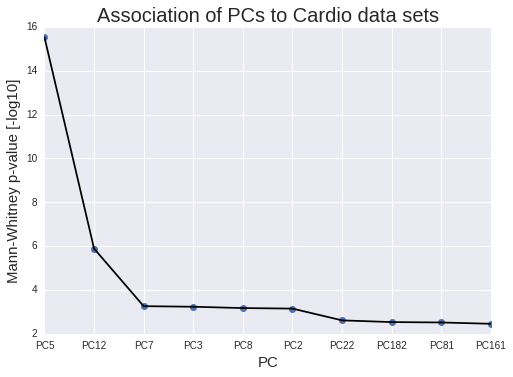

In [410]:
n_pnp = pnp_fd_cnid.shape[0] - 1

mw_p = []
for i in range(200):
    mw_p.append(directed_mannwhitneyu(joined_pca[0:n_pnp,i], joined_pca[n_pnp:,i])[1])
    
min_idx = find_n_minimal_values(mw_p, 10)
mw_p= -np.log10(np.array(mw_p))

plt.plot(range(1,11), mw_p[min_idx], 'o',  range(1,11), mw_p[min_idx], 'k')
plt.xlabel('PC', fontsize=15)
plt.xticks(range(1,11), ['PC' + str(pc+1) for pc in min_idx])
plt.ylabel('Mann-Whitney p-value [-log10]', fontsize=15)
plt.title('Association of PCs to Cardio data sets', fontsize=20)
plt.savefig('figs/DT_Association_of_PCs_to_Cardio.png')
plt.show()

In [375]:
DT_Y = [int(int(s.split('DT')[1].split('_')[0]) in newkit) for s in DT_EMGenes_binary_joined.columns]
DT_Y_bool = np.array([int(s.split('DT')[1].split('_')[0]) in newkit for s in DT_EMGenes_binary_joined.columns])

(-850.0, 0.28847864559759184)


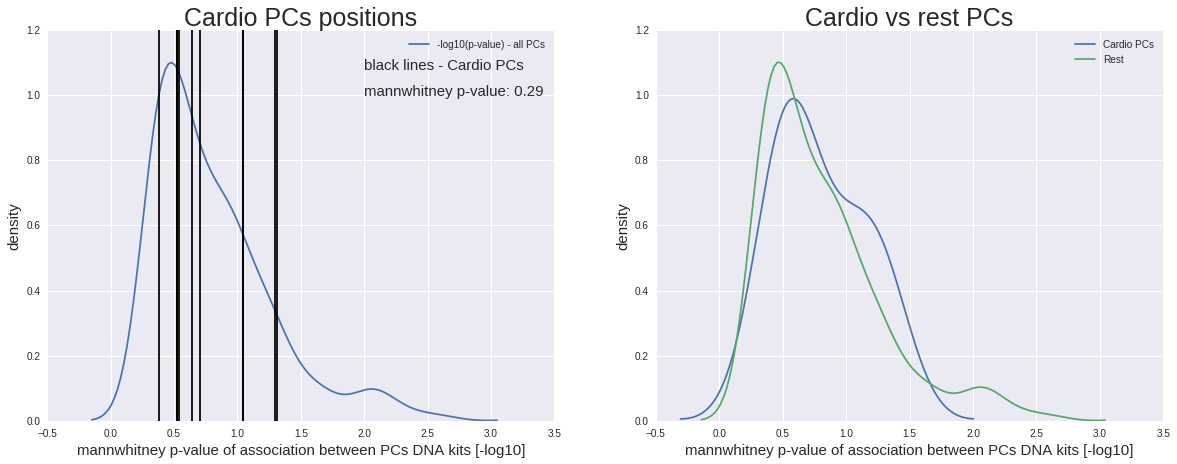

In [477]:
DT_Y_rand = np.random.permutation(DT_Y)
mw_p = []
for i in range(DT_pca.shape[1]):
    mw_p.append(directed_mannwhitneyu(DT_pca[DT_Y_bool,i], DT_pca[~DT_Y_bool,i])[1])
mw_p = -np.log10(np.array(mw_p))
print directed_mannwhitneyu(mw_p[min_idx], mw_p[list(set(range(200)).difference(set(min_idx)))])

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
sns.distplot(mw_p, hist=False, label='-log10(p-value) - all PCs')
for pc in min_idx:
    plt.axvline(x = mw_p[pc], color='black')
plt.title('Cardio PCs positions', fontsize=25)
plt.xlabel('mannwhitney p-value of association between PCs DNA kits [-log10]', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.text(2,1.08, 'black lines - Cardio PCs', fontsize=15)
plt.text(2,1, 'mannwhitney p-value: %0.2f' % directed_mannwhitneyu(mw_p[min_idx], mw_p[list(set(range(200)).difference(set(min_idx)))])[1], fontsize=15)
plt.subplot(1,2,2)
sns.distplot(mw_p[min_idx], hist=False, label='Cardio PCs')
sns.distplot(mw_p[list(set(range(200)).difference(set(min_idx)))], hist=False, label='Rest')
plt.title('Cardio vs rest PCs', fontsize=25)
plt.xlabel('mannwhitney p-value of association between PCs DNA kits [-log10]', fontsize=15)
plt.ylabel('density', fontsize=15)
plt.savefig('figs/DT_positions_of_Cardio_PCs.png')
plt.show()

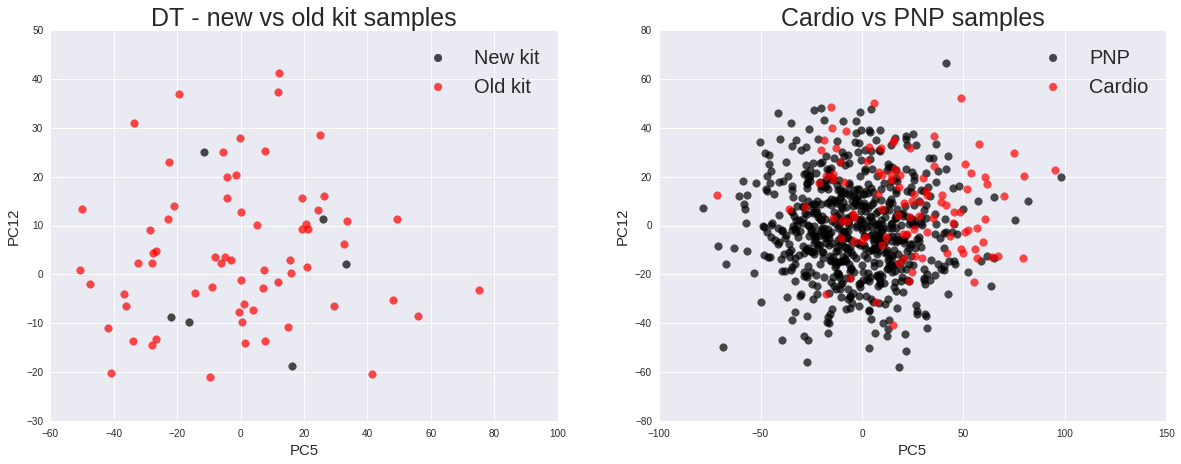

In [463]:
PC1 = 4
PC2 = 11
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.scatter(DT_pca[DT_Y_bool,PC1], DT_pca[DT_Y_bool,PC2], label = 'New kit', s=60, color='black', alpha=0.7)
plt.scatter(DT_pca[~DT_Y_bool,PC1], DT_pca[~DT_Y_bool,PC2], label = 'Old kit', s=60, color='red', alpha=0.7)
plt.title('DT - new vs old kit samples', fontsize=25)
plt.xlabel('PC' + str(PC1+1), fontsize=15)
plt.ylabel('PC' + str(PC2+1), fontsize=15)
plt.legend(loc='upper right', fontsize=20)
plt.subplot(1,2,2)
plt.scatter(joined_pca[:n_pnp,PC1], joined_pca[:n_pnp,PC2], label = 'PNP', s=60, color='black', alpha=0.7)
plt.scatter(joined_pca[n_pnp:,PC1], joined_pca[n_pnp:,PC2], label = 'Cardio', s=60, color='red', alpha=0.7)
plt.title('Cardio vs PNP samples', fontsize=25)
plt.xlabel('PC' + str(PC1+1), fontsize=15)
plt.ylabel('PC' + str(PC2+1), fontsize=15)
plt.legend(loc='upper right', fontsize=20)
plt.savefig('figs/DT_most_significant_PCs_by_Cardio.png')
plt.show()

# TMA analysis

In [265]:
# CutD - http://www.uniprot.org/uniprot/Q30W71.fasta
# CutC - http://www.uniprot.org/uniprot/Q30W70.fasta
# CntA - http://www.uniprot.org/uniprot/D0C9N6.fasta
# CntB - http://www.uniprot.org/uniprot/D0C9N8.fasta
# CaiX - http://www.pseudomonas.com/feature/show/?id=113660&view=sequence
# CaiT - http://www.uniprot.org/uniprot/P31553.fasta
# CntA_genebank and CutC_genebank by ids from https://microbiomejournal.biomedcentral.com/articles/10.1186/s40168-017-0271-9 (genebank)

In [281]:
kegg = KEGG_data_holder()

2017-12-16 11:41:02.335069 - [KEGG_data_holder._build_dicts] building url drug_pathway
2017-12-16 11:41:06.400401 - [KEGG_data_holder._build_dicts] building url pathway_ko
2017-12-16 11:41:15.221423 - [KEGG_data_holder._build_dicts] building url drug_ko
2017-12-16 11:41:17.133439 - [KEGG_data_holder._build_dicts] building url reaction_ko
2017-12-16 11:41:18.702701 - [KEGG_data_holder._build_dicts] building url compound_reaction
2017-12-16 11:41:30.986579 - [KEGG_data_holder._build_dicts] building url compound_pathway
2017-12-16 11:41:33.403535 - [KEGG_data_holder._build_dicts] building url compound_module
2017-12-16 11:41:34.352725 - [KEGG_data_holder._build_dicts] building url module_ko
2017-12-16 11:41:35.550661 - [KEGG_data_holder._build_KEGG_COG_dict] loading KEGG_COG dict
2017-12-16 11:44:06.114346 - [KEGG_data_holder._build_KEGG_COG_dict] parsing ko_bacgene dict
2017-12-16 11:44:24.037025 - [KEGG_data_holder._build_KEGG_COG_dict] parsing cog_bacgene dict
2017-12-16 11:44:49.68335

## get relevant KEGG reactions

In [38]:
# find all reactions that are associated with TMA and other known factors
# TMA KEGG: C00565
tma_reactions = kegg.get_dicts()['compound_reaction']['cpd:C00565']
# CutC ko:K20038 cog:COG1882
CutC_genes = kegg.get_dicts()['cog_bacgene']['cog:COG1882']
# CutD ko:K20037 cog:COG1180
CutD_genes = kegg.get_dicts()['cog_bacgene']['cog:COG1180']
# caiB ko:K08298 cog:COG1804
caiB_ko_genes = kegg.get_dicts()['ko_bacgene']['ko:K08298']
caiB_cog_genes = kegg.get_dicts()['cog_bacgene']['cog:COG1804']

In [48]:
if not 'joined_em' in locals():
    joined_em = read_csv('EMGenes_joined.csv')
    joined_em = joined_em.set_index('Unnamed: 0')

In [145]:
# create distance matices by CutC and CutD genes
temp_mat = joined_em.loc[CutC_genes, :].dropna(how='all', axis=0).T.copy()
distance_by_CutC_genes = compute_distance_matrix(temp_mat, BrayCurtis)
temp_mat[temp_mat>0] = 1
distance_by_CutC_genes_BinEuc = compute_distance_matrix(temp_mat, pdist)

temp_mat = joined_em.loc[CutD_genes, :].dropna(how='all', axis=0).T.copy()
distance_by_CutD_genes = compute_distance_matrix(temp_mat, BrayCurtis)
temp_mat[temp_mat>0] = 1
distance_by_CutD_genes_BinEuc = compute_distance_matrix(temp_mat, pdist)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750


In [146]:
print mantel_test(distance_by_CutC_genes.fillna(0), data_distances, perms=1000, method='pearson', tail='upper')
print mantel_test(distance_by_CutC_genes_BinEuc, data_distances, perms=1000, method='pearson', tail='upper')
print mantel_test(distance_by_CutD_genes.fillna(0), data_distances, perms=1000, method='pearson', tail='upper')
print mantel_test(distance_by_CutD_genes_BinEuc, data_distances, perms=1000, method='pearson', tail='upper')

(-0.024061073128022643, 0.87, -1.1482560480932122)
(-0.0091956490239475889, 0.67100000000000004, -0.4665469685877221)
(0.039176659567796326, 0.042999999999999997, 1.9040717652649155)
(0.037213849354887862, 0.055, 1.718938974560654)


In [150]:
temp_mat = joined_em.loc[CutD_genes, :].dropna(how='all', axis=0).copy()
print directed_mannwhitneyu(temp_mat.loc[:,cardio_fd_spid.FD_SPID].stack(), temp_mat.loc[:, pnp_fd_cid_spid.FD_SPID].stack())

temp_mat = joined_em.loc[CutC_genes, :].dropna(how='all', axis=0).copy()
print directed_mannwhitneyu(temp_mat.loc[:,cardio_fd_spid.FD_SPID].stack(), temp_mat.loc[:, pnp_fd_cid_spid.FD_SPID].stack())

temp_mat = joined_em.loc[caiB_cog_genes, :].dropna(how='all', axis=0).copy()
print directed_mannwhitneyu(temp_mat.loc[:,cardio_fd_spid.FD_SPID].stack(), temp_mat.loc[:, pnp_fd_cid_spid.FD_SPID].stack())

(-8494173.0, 0.44238576925687145)
(-8453670.0, 0.28851696920188308)
(128272.0, 0.074436932882305351)


In [157]:
for reac in tma_reactions:
    if reac not in kegg.get_dicts()['reaction_ko']:
        print reac + " doesn't have kos"
        continue
    reac_kos = kegg.get_dicts()['reaction_ko'][reac]
    reac_bac_genes = []
    for ko in reac_kos:
        if ko in kegg.get_dicts()['ko_bacgene']:
            reac_bac_genes += kegg.get_dicts()['ko_bacgene'][ko]
    reac_bac_genes = list(set(reac_bac_genes))
    if len(reac_bac_genes) == 0:
        print reac + " doesn't have bac genes"
        continue
    print reac
    print len(reac_bac_genes)
    if len(set(reac_bac_genes).intersection(set(joined_em.index))) == 0:
        print "no genes in matrix"
        continue
    temp_mat = joined_em.loc[reac_bac_genes, :].dropna(how='all', axis=0).copy()
    print temp_mat.shape
    print temp_mat.index

rn:R02511
4
no genes in matrix
rn:R02559 doesn't have kos
rn:R02560 doesn't have kos
rn:R04877 doesn't have kos
rn:R05623 doesn't have bac genes
rn:R07228 doesn't have kos
rn:R09124
239
(1, 759)
Index([u'158499257-stool1_revised_C1448252_1_gene95279'], dtype='object', name=u'Unnamed: 0')
rn:R10016
149
no genes in matrix
rn:R10017 doesn't have kos
rn:R10285 doesn't have kos


## build protein reference data base based on KEGG

In [249]:
def KEGG_create_gene_db_from_KO(ko, outdir, aa_dna='protein'):
    base_urls = {'protein':'http://www.genome.jp/dbget-bin/www_bget?-f+-n+a+', 
                 'dna':'http://www.genome.jp/dbget-bin/www_bget?-f+-n+n+'}
    KEGG_ORGANISM_LIST_URL = 'http://rest.kegg.jp/list/organism'
    url_organism_list = urllib2.urlopen(KEGG_ORGANISM_LIST_URL, timeout=20).readlines()
    url_organism_dict = {org.split()[1]:org.split('\n')[0] for org in url_organism_list}
    LEGAL_SEQ = ['protein', 'dna']
    if aa_dna not in LEGAL_SEQ:
        print(str(datetime.now()) + " - [KEGGDataBuilder.KEGG_create_gene_db_from_KO] aa_dna must be one of: " 
              + ", ".join(LEGAL_SEQ))
        return
    BASE_URL = base_urls[aa_dna]
    
    if not re.match('^K[0-9]+$', ko):
        print(str(datetime.now()) + " - [KEGGDataBuilder.KEGG_create_gene_db_from_KO] KO name " 
              + ko + " isn't legal")
        return
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    url = 'http://rest.kegg.jp/link/genes/' + ko
    url_genes = urllib2.urlopen(url, timeout=20).readlines()
    genes = [gene.split('\n')[0].split()[1] for gene in url_genes]
    genes_seq = {}
    with open('/'.join([outdir, ko + '_'+ aa_dna + '.fa']), 'w') as handle:
        print(str(datetime.now()) + " - [KEGGDataBuilder.KEGG_create_gene_db_from_KO] will parse " 
              + str(len(genes)) + " genes")
        c = 0
        for gene in genes:
            c += 1
            if c % 10 == 0:
                print c
            if not bool(re.match('.*Bacteria.*', url_organism_dict[gene.split(':')[0]])):
                print gene.split(':')[0]
                continue
            url = BASE_URL + gene
            url_text = urllib2.urlopen(url, timeout=20).readlines()
            text = ''.join([t.split('\n')[0] for t in url_text if (t[0] != '<') & bool((re.match('[a-zA-Z]+', t)))])
            if text in genes_seq.values():
                continue
            genes_seq[gene] = text
            handle.write('>' + gene + '\n')
            handle.write(text + '\n')
            
    return

## Running DIAMOND over samples

In [248]:
KEGG_create_gene_db_from_KO('K20038', '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/KEGG_to_genes_DB/', 'protein')
KEGG_create_gene_db_from_KO('K20038', '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/KEGG_to_genes_DB/', 'dna')
KEGG_create_gene_db_from_KO('K20037', '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/KEGG_to_genes_DB/', 'protein')
KEGG_create_gene_db_from_KO('K20037', '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/KEGG_to_genes_DB/', 'dna')

2017-12-05 17:56:24.215124 - [KEGGDataBuilder.KEGG_create_gene_db_from_KO] will parse 137 genes
0
10
20
30
40
50
60
70
80
90
100
110
loki
2017-12-05 17:58:26.879444 - [KEGGDataBuilder.KEGG_create_gene_db_from_KO] will parse 137 genes
0
10
20
30
40
50
60
70
80
90
100
110
loki
2017-12-05 18:00:31.084743 - [KEGGDataBuilder.KEGG_create_gene_db_from_KO] will parse 110 genes
0
10
20
30
40
40
40
40
50
60
70
80
90
2017-12-05 18:02:12.210334 - [KEGGDataBuilder.KEGG_create_gene_db_from_KO] will parse 110 genes
0
10
20
30
40
50
60
70
80
90


In [563]:
gene_references = ['K20037',  'K20038', 'CaiT', 'CaiX', 'CntA', 'CntB', 'CutC', 'CutD', 'CntA_GeneBank',  'CutC_GeneBank', 'YeaX', 'YeaW']
gene_references = ['CaiT', 'CaiX', 'CntA', 'CntB', 'CutC', 'CutD', 'YeaX', 'YeaW']
gene_reference_max = {}
gene_reference_max_vals = {}

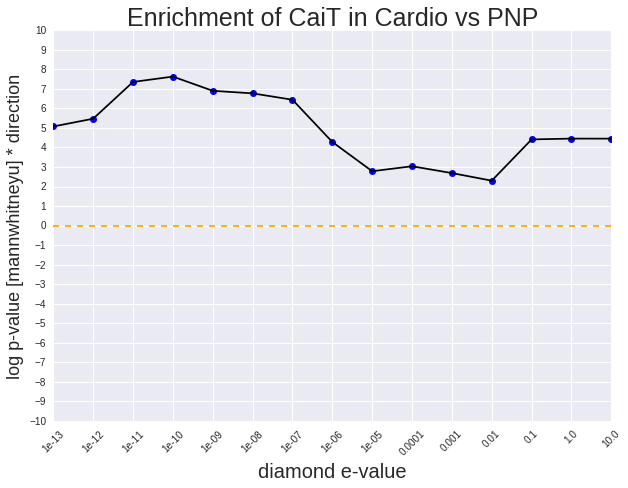

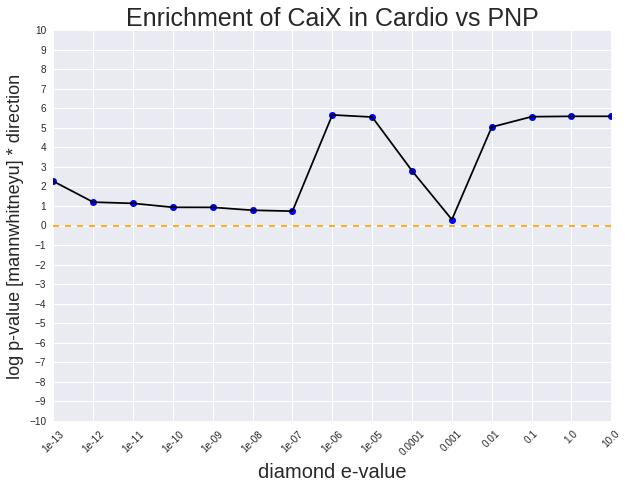

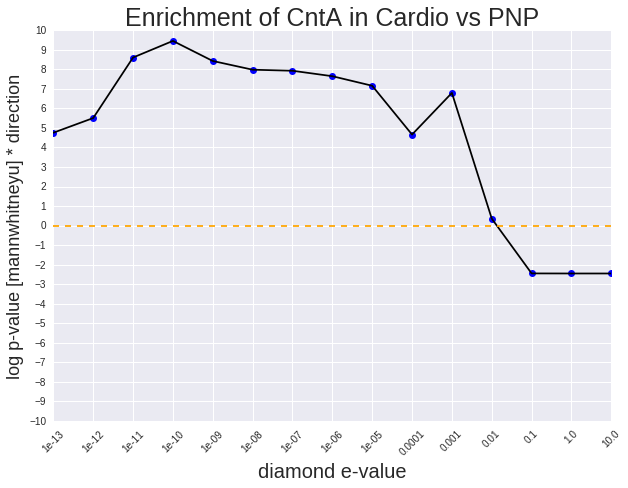

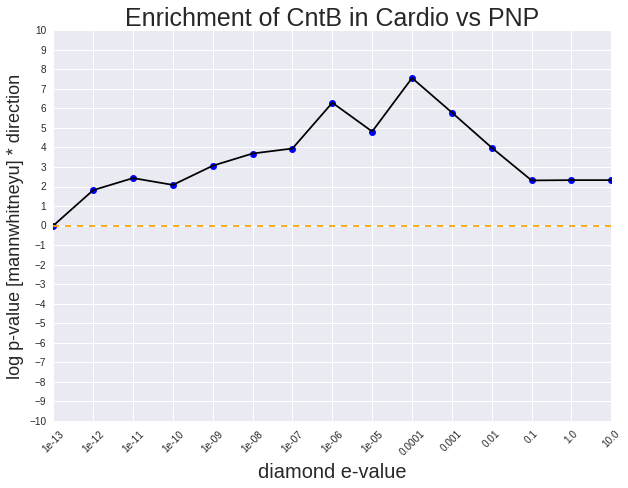

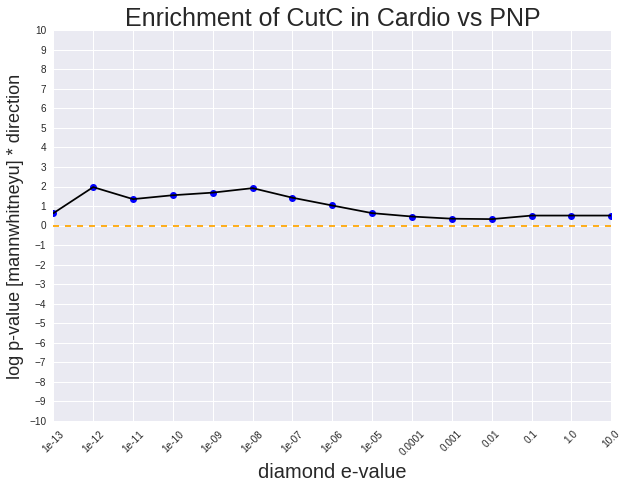

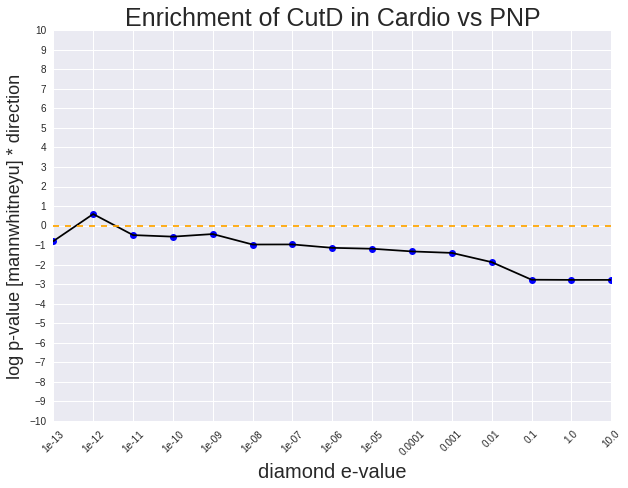

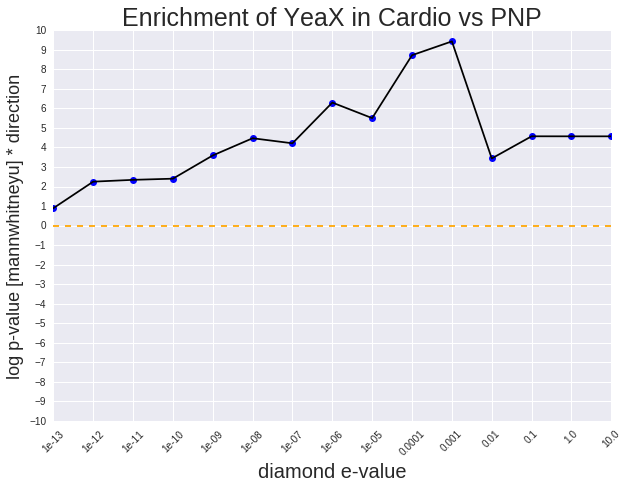

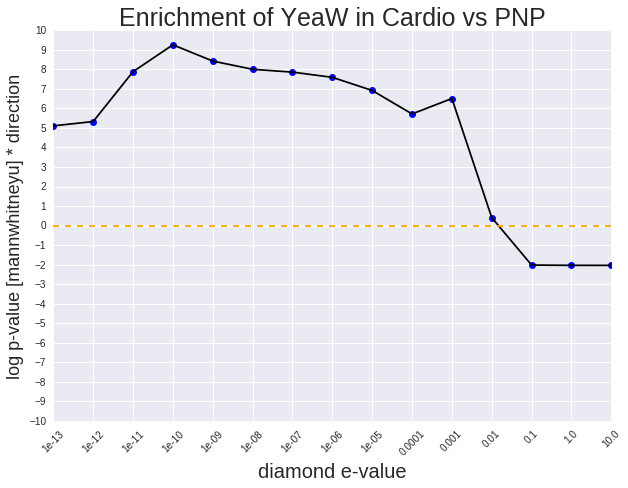

In [564]:
for ko_reference in gene_references:
    counts = Utils.Load('DIAMOND/' + ko_reference +'_protein/counts.dat')
    pnp_fd_cid_spid['SS'] = [min(10000000., pnp_fd_cid_spid.iloc[s, :]['PostHGF']) for s in range(pnp_fd_cid_spid.shape[0])]
    cardio_fd_spid['SS'] = [min(10000000., cardio_fd_spid.iloc[s, :]['PostHGF']) for s in range(cardio_fd_spid.shape[0])]

    ko_pvals = []
#     plt.figure(figsize=(30,10))
    for i in range(counts.shape[1]):
#         plt.subplot(3,5,i+1)
        ko_pnp = counts.loc[pnp_fd_cid_spid.FD_SPID][counts.columns[i]].values / pnp_fd_cid_spid['SS']
        ko_cardio = counts.loc[cardio_fd_spid.FD_SPID][counts.columns[i]].values / cardio_fd_spid['SS']
#         ko_pnp = ko_pnp.clip_upper(threshold=ko_pnp.quantile(0.99))
#         ko_cardio = ko_cardio.clip_upper(threshold=ko_cardio.quantile(0.99))
#         sns.distplot(ko_pnp, hist=False, label='PNP')
#         sns.distplot(ko_cardio, hist=False, label='cardio')
#         plt.title(counts.columns[i])
#         plt.xlabel('abundance')
        if len(set(ko_cardio).union(set(ko_pnp))) == 1:
            s = 0
            p = 1
        else:
            s, p = directed_mannwhitneyu(ko_cardio, ko_pnp)
        ko_pvals.append(np.log10(p) * np.sign(s))
    gene_reference_max[ko_reference] = counts.columns[np.argmax(abs(np.array(ko_pvals)))]
    gene_reference_max_vals[ko_reference] = ko_pvals[np.argmax(abs(np.array(ko_pvals)))]
#     plt.show()

    plt.clf()
    plt.figure(figsize=(10,7))
    my_xticks = counts.columns
    plt.xticks(range(counts.shape[1]), my_xticks, rotation=45)
    plt.yticks(range(-10,11))
    plt.xlabel('diamond e-value', fontsize=20)
    plt.ylabel('log p-value [mannwhitneyu] * direction', fontsize=18)
    plt.ylim((-10,10))
    plt.plot(range(counts.shape[1]), ko_pvals, 'bo', range(counts.shape[1]), ko_pvals, 'k')
    plt.plot(range(counts.shape[1]), [0]*counts.shape[1], '--', color='orange')
    plt.title('Enrichment of ' + ko_reference + ' in Cardio vs PNP', fontsize=25)
    plt.savefig('DIAMOND/cardio_enrichment_' + ko_reference + '.png')
    plt.show()
    # positive values indicates higher values for first value (Cardio)

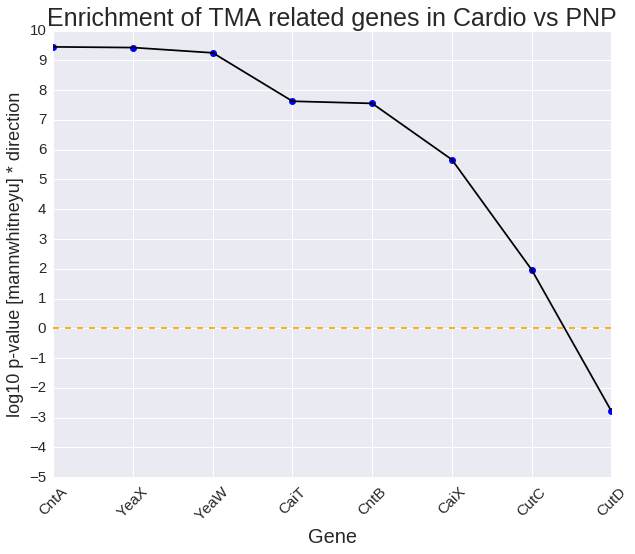

In [577]:
gene_reference_max_vals_df = pd.DataFrame()
gene_reference_max_vals_df['gene'] = gene_reference_max_vals.keys()
gene_reference_max_vals_df['vals'] = gene_reference_max_vals.values()
gene_reference_max_vals_df = gene_reference_max_vals_df.sort_values('vals', ascending=False)
nrow = gene_reference_max_vals_df.shape[0]
# plt.clf()
plt.figure(figsize=(10,8))
my_xticks = gene_reference_max_vals_df['gene']
plt.xticks(range(nrow), my_xticks, rotation=45, fontsize=15)
plt.yticks(range(-5,11), fontsize=15)
plt.xlabel('Gene', fontsize=20)
plt.ylabel('log10 p-value [mannwhitneyu] * direction', fontsize=18)
plt.ylim((-5,10))
plt.plot(range(nrow), gene_reference_max_vals_df['vals'], 'bo', range(nrow), gene_reference_max_vals_df['vals'], 'k')
plt.plot(range(nrow), [0]*nrow, '--', color='orange')
plt.title('Enrichment of TMA related genes in Cardio vs PNP', fontsize=25)
plt.savefig('DIAMOND/cardio_enrichment_TMA_genes.png')
plt.show()

## Predictor using TMA genes

In [536]:
# tma_dict =  {'K20038':1e-9, 'CaiT':1e-7, 'CaiX':1e-5, 'CntA':1, 'CntB':0.0001, 'CutC':1, 'CutD':1, 'CntA_GeneBank':1e-5,  'CutC_GeneBank':1e-8, 'YeaX':0.001, 'YeaW':1e-10}
tma_dict = gene_reference_max

X = pd.DataFrame()
for gene in tma_dict:    
    counts = Utils.Load('DIAMOND/' + gene + '_protein/counts.dat')
    x_temp = counts[tma_dict[gene]]
    x_temp.name = gene
    X = pd.concat((X, x_temp), axis=1)
X['Y'] = 0
X.loc[cardio_fd_spid.FD_SPID, 'Y'] = 1
Y = X['Y'].copy()
X = X.select(lambda x: x is not 'Y', axis=1)

Utils.Write('DIAMOND/TMA_genes_X.dat', X.values)
Utils.Write('DIAMOND/TMA_genes_Y.dat', Y.values)

In [580]:
pred_results = Utils.Load('DIAMOND/predictions/final_predictions.dat')
pred_results.sort_values('auc').tail(10)
# plt.scatter(range(pred_results.shape[0]), pred_results.sort_values('auc')['auc'])
# plt.show()

,X,auc,dim_red_method,k_fold,learning_rate,max_depth,max_features,min_samples_split,n_estimators,n_pcs,project_test_data,random_state,samples_weight,subsample
281,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.751183,None,9,0.0010,3,0.5,4,8000,100,False,5,7,0.1
15,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.752580,None,20,0.0050,2,0.7,4,1000,170,False,0,2,0.3
861,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.752716,None,9,0.0010,2,0.3,3,6000,155,False,1,6,0.5
796,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.753241,None,25,0.0020,3,0.4,4,1000,185,False,2,3,0.3
881,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.753482,None,20,0.0010,3,0.5,6,4500,105,False,1,2,0.1
319,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.754579,None,9,0.0075,5,0.5,3,4500,100,False,4,3,0.2
429,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.754759,None,15,0.0010,2,0.4,2,2500,110,False,2,2,0.4
110,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.754909,None,15,0.0010,4,0.5,4,1500,175,False,1,3,0.1
288,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.755195,None,13,0.0020,2,0.3,2,1000,195,False,5,2,0.1
8,/net/mraid08/export/jafar/Microbiome/Analyses/...,0.756772,None,15,0.0020,3,0.6,2,500,130,False,1,4,0.2


In [557]:
params = {'n_estimators':500, 'learning_rate':0.002, 'max_depth':3, 'random_state':1, 'subsample': 0.2, 'max_features':0.6, 'min_samples_split':2}
X = Utils.Load('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/Cardio07112017/DIAMOND/TMA_genes_X.dat')
Y = Utils.Load('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/Cardio07112017/DIAMOND/TMA_genes_Y.dat')

groups = np.array(range(len(X)))
group_kfold = GroupKFold(n_splits=15)

final_pred = np.array([])
final_test =  np.array([])

i = 0
for train_index, test_index in group_kfold.split(X, Y, groups):
    print i
    i += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    est = GradientBoostingClassifier(**params).fit(X_train, y_train, sample_weight=(y_train*4)+1)
    vals = est.predict_proba(X_test)
    final_pred = np.concatenate((final_pred, vals[:,1]))
    final_test = np.concatenate((final_test, y_test))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


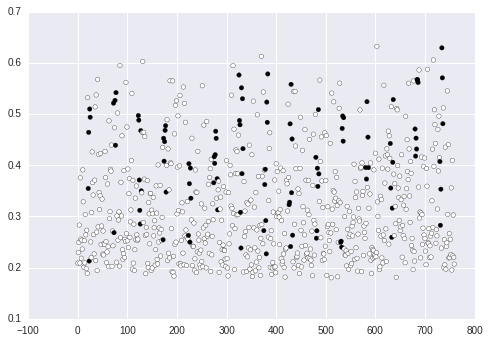

0.756772187082


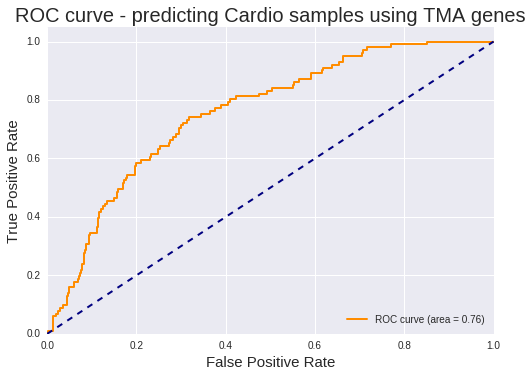

In [558]:
predictions_df = pd.DataFrame()
predictions_df['pred'] = final_pred
predictions_df['val'] = final_test
predictions_df = predictions_df.sort_values('pred')
plt.scatter(range(len(final_pred)), final_pred, c=final_test)
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(final_test+1, final_pred, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
print roc_auc

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve - predicting Cardio samples using TMA genes', fontsize=20)
plt.legend(loc="lower right")
plt.savefig('figs/TMA_genes_ROC.png')
plt.show()

# Specific KO/Pathways enrichment

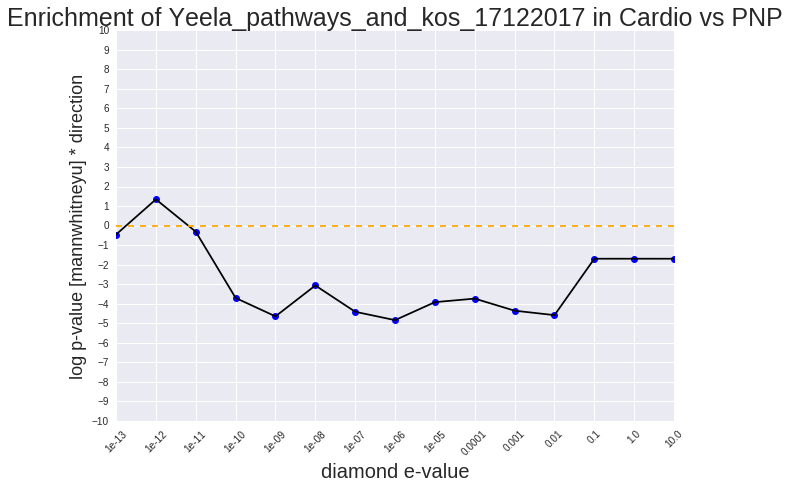

In [358]:
for ko_reference in ['Yeela_pathways_and_kos_17122017']:
# for ko_reference in ['CutD', 'K20037', 'CntA_GeneBank', 'CutC_GeneBank',  'K20038']:
    counts = Utils.Load('DIAMOND/' + ko_reference +'_protein/counts.dat')
    pnp_fd_cid_spid['SS'] = [min(10000000., pnp_fd_cid_spid.iloc[s, :]['PostHGF']) for s in range(pnp_fd_cid_spid.shape[0])]
    cardio_fd_spid['SS'] = [min(10000000., cardio_fd_spid.iloc[s, :]['PostHGF']) for s in range(cardio_fd_spid.shape[0])]

    ko_pvals = []
#     plt.figure(figsize=(30,10))
    for i in range(counts.shape[1]):
#         plt.subplot(3,5,i+1)
        ko_pnp = counts.loc[pnp_fd_cid_spid.FD_SPID][counts.columns[i]].values / pnp_fd_cid_spid['SS']
        ko_cardio = counts.loc[cardio_fd_spid.FD_SPID][counts.columns[i]].values / cardio_fd_spid['SS']
#         ko_pnp = ko_pnp.clip_upper(threshold=ko_pnp.quantile(0.99))
#         ko_cardio = ko_cardio.clip_upper(threshold=ko_cardio.quantile(0.99))
#         sns.distplot(ko_pnp, hist=False, label='PNP')
#         sns.distplot(ko_cardio, hist=False, label='cardio')
#         plt.title(counts.columns[i])
#         plt.xlabel('abundance')
        if len(set(ko_cardio).union(set(ko_pnp))) == 1:
            s = 0
            p = 1
        else:
            s, p = directed_mannwhitneyu(ko_cardio, ko_pnp)
#         print s,p
#         print ko_pnp.mean(), ko_cardio.mean()
        ko_pvals.append(np.log10(p) * np.sign(s))
#     plt.show()

    plt.clf()
    plt.figure(figsize=(10,7))
    my_xticks = counts.columns
    plt.xticks(range(counts.shape[1]), my_xticks, rotation=45)
    plt.yticks(range(-10,11))
    plt.xlabel('diamond e-value', fontsize=20)
    plt.ylabel('log p-value [mannwhitneyu] * direction', fontsize=18)
    plt.ylim((-10,10))
    plt.plot(range(counts.shape[1]), ko_pvals, 'bo', range(counts.shape[1]), ko_pvals, 'k')
    plt.plot(range(counts.shape[1]), [0]*counts.shape[1], '--', color='orange')
    plt.title('Enrichment of ' + ko_reference + ' in Cardio vs PNP', fontsize=25)
#     plt.savefig('DIAMOND/cardio_enrichment_' + ko_reference + '.png')
    plt.show()

In [302]:
print datetime.now()
protein_fasta = read_fasta_to_dict('../../KEGG_DB_12_12_2017/KEGG_genes_Bacteria_protein.fa')
print datetime.now()

2017-12-17 14:37:50.181248
2017-12-17 14:42:12.257592


In [303]:
kos_genes_dict = Utils.Load('../../KEGG_DB_12_12_2017/kos_genes_dict.dat')

In [304]:
kos_genes_dict.keys()[0:4]

['ko:K00127', 'ko:K07708', 'ko:K07709', 'ko:K12152']

In [470]:
# Cholesterol metabolism:
# pathway: ko04979
# ApoE (cholesterol metabolism) - K04524

# Coagulation and complement:
# pathway: ko04610
#B2G1(coagulation) - K17305 

# Inflammation:
# IL-beta 1 - KO4519
# MAPK signaling pathway (ko04010)
# NF-kappa B signaling pathway (ko04064)
# Toll-like receptor signaling pathway (ko04620)
# AGE-RAGE signaling pathway in diabetic complications (ko04933)
# TNF signaling pathway (ko04668)
pathways = ['04979', '04610', '04010', '04064', '04620', '04933', '04668']
kos = ['04524', '17305', '04519']

In [324]:
build_fasta_file_for_KEGG_compartments(protein_fasta, kegg, kos_genes_dict, '../../KEGG_DB_12_12_2017/Yeela_pathways_and_kos_17122017.fa', pathways=['04979', '04610', '04010', '04064', '04620', '04933', '04668'], reactions=None, modules=None, kos=['04524', '17305', '04519'])

path:map04979
path:map04610
path:map04010
path:map04064
path:map04620
path:map04933
path:map04668
1027
1027


In [319]:
'ko:KO4519' in kegg.get_dicts()['pathway_ko']['path:map' + '04668']

False

In [471]:
# pathways = [ '04064']
all_genes = []
for p in pathways:
    p_genes = []
    n_genes = 0
    pw = 'path:map' + p
    print pw
    temp_kos = kegg.get_dicts()['pathway_ko'][pw]
    print len(temp_kos)
    for ko in temp_kos:
        if ko in kos_genes_dict:
            temp_genes = kos_genes_dict[ko]
            for g in temp_genes:
                
                all_genes.append(g)
                if g in protein_fasta:
                    p_genes.append(g)
                    n_genes += 1
    print n_genes
    print len(p_genes)
print
print len(all_genes)
print len(set(all_genes))

# for k in kos:
#     ko = 'ko:K' + k
#     print ko
#     print len(kegg.get_dicts()['ko_bacgene'][ko])

# kegg.get_dicts()['pathway_ko']['path:map04668']

path:map04979
49
952
952
path:map04610
78
4
4
path:map04010
227
6
6
path:map04064
89
22
22
path:map04620
76
0
0
path:map04933
74
19
19
path:map04668
88
24
24

139449
101835


In [465]:
p_genes

['neu:NE1240',
 'nco:AAW31_14550',
 'rei:IE4771_PB00086',
 'met:M446_1624',
 'mno:Mnod_6498',
 'rsh:Rsph17029_3626',
 'rsk:RSKD131_4262',
 'rde:RD1_1072',
 'rli:RLO149_c002730',
 'lmd:METH_17860',
 'mva:Mvan_3099',
 'mcb:Mycch_2784',
 'srw:TUE45_00459',
 'sro:Sros_8745',
 'gob:Gobs_1219',
 'len:LEP3755_10380',
 'glp:Glo7428_2177',
 'mic:Mic7113_3623',
 'oni:Osc7112_4273',
 'npu:Npun_R5469',
 'nos:Nos7107_2301',
 'csg:Cylst_1559']

In [456]:
KEGG_ORGANISM_LIST_URL = 'http://rest.kegg.jp/list/organism'
url_organism_list = urllib2.urlopen(KEGG_ORGANISM_LIST_URL, timeout=20).readlines()
url_organism_dict = {org.split()[1]:org.split('\n')[0] for org in url_organism_list}

In [467]:
[gene for gene in kos_genes_dict['ko:K01343'] if bool(re.match('.*Bacteria.*', url_organism_dict[gene.split(':')[0]]))]

['bbt:BBta_1433']

In [455]:
kos_genes_dict['ko:K04519']

['hsa:3553',
 'ptr:450200',
 'pps:100993613',
 'ggo:101130571',
 'pon:100454379',
 'nle:100587357',
 'mcc:704701',
 'mcf:102119749',
 'csab:103241278',
 'rro:104672547',
 'rbb:108541809',
 'cjc:100406769',
 'sbq:101033664',
 'mmu:16176',
 'rno:24494',
 'cge:100775079',
 'ngi:103739899',
 'hgl:101704309',
 'ccan:109701168',
 'ocu:100008990',
 'tup:102475138',
 'cfa:403974',
 'aml:100480874',
 'umr:103671495',
 'oro:101383005',
 'fca:768274',
 'ptg:102951272',
 'aju:106976013',
 'bta:281251',
 'bom:102282890',
 'biu:109566133',
 'phd:102329073',
 'chx:100860816',
 'oas:443539',
 'ssc:396565',
 'ssc:397122',
 'cfr:102521979',
 'cdk:105093155',
 'bacu:103008438',
 'lve:103090784',
 'ecb:100034237',
 'ecb:100052414',
 'epz:103544835',
 'eai:106838557',
 'myb:102251576',
 'myd:102769803',
 'hai:109393524',
 'rss:109435855',
 'pale:102893238',
 'lav:100674746',
 'tmu:101359415',
 'mdo:100026024',
 'shr:100922350',
 'oaa:103165286',
 'gga:395196',
 'mgp:100034741',
 'cjo:107323637',
 'tgu:1002

In [359]:
genes_kos_dict = Utils.Load('../../KEGG_DB_12_12_2017/genes_kos_dict.dat')

In [360]:
len(genes_kos_dict)

11477406

In [371]:
def find_pos(border_vals, val):
    pos = 0
    while pos < len(border_vals):
        if val > border_vals[pos]:
            pos += 1
        else:
            break
    return pos

find_pos([1,2,3,4,5,6], 3.5)

3

In [399]:
# fd_file = 'DIAMOND/Yeela_pathways_and_kos_17122017_protein/FD2522_1458.diam'
# border_vals = [10./10**(s) for s in range(15)]
# border_vals.reverse()
# counts_df = pd.DataFrame(index=pd.MultiIndex(levels=[[], []], labels=[[], []], names=['sample', 'KO']), columns=border_vals)


# for line in open(fd_file, 'r'):
#     fields = line.split()
#     kos = genes_kos_dict[fields[1]]
#     for ko in kos:
#         if fd_file in counts_df.index.get_level_values(0) and (fd_file, ko) in counts_df.index:
#             vals = counts_df.loc[(fd_file, ko)].values
#             pos = find_pos(border_vals, float(fields[10]))
#             vals[pos:] = vals[pos:] + 1
#             counts_df.loc[(fd_file, ko), :] = vals
#         else:
#             vals = np.zeros((counts.shape[1]))
#             pos = find_pos(border_vals, float(fields[10]))
#             vals[pos:] = vals[pos:] + 1
#             counts_df.loc[(fd_file, ko), :] = vals
counts_df
# kos

1.000000e-13  \
sample                                             KO                       
DIAMOND/Yeela_pathways_and_kos_17122017_protein... ko:K05770            0   
                                                   ko:K11987            0   
                                                   ko:K01343            0   
                                                   ko:K06236            0   
                                                   ko:K19720            0   
                                                   ko:K04373            0   
                                                   ko:K04459            0   
                                                   ko:K21278            0   
                                                   ko:K01315            0   
                                                   ko:K15637            0   
                                                   ko:K00650            0   
                                                   ko:K06237            0   
                                                   ko:K16342            0   
                                                   ko:K06268            0   

                                                             1.000000e-12  \
sample                                             KO                       
DIAMOND/Yeela_pathways_and_kos_17122017_protein... ko:K05770            0   
                                                   ko:K11987            0   
                                                   ko:K01343            0   
                                                   ko:K06236            0   
                                                   ko:K19720            0   
                                                   ko:K04373            0   
                                                   ko:K04459            0   
                                                   ko:K21278            0   
                                                   ko:K01315            0   
                                                   ko:K15637            0   
                                                   ko:K00650            0   
                                                   ko:K06237            0   
                                                   ko:K16342            0   
                                                   ko:K06268            0   

                                                             1.000000e-11  \
sample                                             KO                       
DIAMOND/Yeela_pathways_and_kos_17122017_protein... ko:K05770            3   
                                                   ko:K11987            0   
                                                   ko:K01343            0   
                                                   ko:K06236            0   
                                                   ko:K19720            0   
                                                   ko:K04373            0   
                                                   ko:K04459            0   
                                                   ko:K21278            0   
                                                   ko:K01315            0   
                                                   ko:K15637            0   
                                                   ko:K00650            0   
                                                   ko:K06237            0   
                                                   ko:K16342            0   
                                                   ko:K06268            0   

                                                             1.000000e-10  \
sample                                             KO                       
DIAMOND/Yeela_pathways_and_kos_17122017_protein... ko:K05770            8   
                                                   ko:K11987            0   
                                                   ko:

In [422]:
df = Utils.Load('DIAMOND/Yeela_pathways_and_kos_17122017_protein/counts_divide_by_ko_0.0001.dat')
df.columns

Index([u'ko:K05770', u'ko:K01343', u'ko:K06236', u'ko:K04373', u'ko:K11987',
       u'ko:K19720', u'ko:K01315', u'ko:K15637', u'ko:K04459', u'ko:K00650',
       u'ko:K21278', u'ko:K16342', u'ko:K06237', u'ko:K06268'],
      dtype='object')

In [423]:
for k in df.columns:
    print k
    try:
        print directed_mannwhitneyu(df[k].loc[cardio_fd_spid.FD_SPID], df[k].loc[pnp_fd_cid_spid.FD_SPID])
    except:
        print 0    

ko:K05770
(-32967.5, 0.43974185820714518)
ko:K01343
(25906.5, 0.00016629867983078013)
ko:K06236
(28834.0, 0.015223734212175304)
ko:K04373
(25677.5, 9.529127204229839e-05)
ko:K11987
(-33102.0, 0.24590577571463823)
ko:K19720
(27192.0, 0.001382461967103566)
ko:K01315
(-33024.5, 0.26512272574356366)
ko:K15637
(33229.0, 0.34915179441760019)
ko:K04459
(33229.0, 0.34915179441760019)
ko:K00650
0
ko:K21278
(33178.5, 0.29072447793277018)
ko:K16342
(33178.5, 0.29072447793277018)
ko:K06237
0
ko:K06268
0


In [469]:
directed_mannwhitneyu([8,9,9], [5,6,7])

(-1e-10, 0.038261250237529611)

In [429]:
df['ko:K04373']
k='ko:K04373'
df[k].loc[cardio_fd_spid.FD_SPID].median()
df[k].loc[pnp_fd_cid_spid.FD_SPID].median()

3.0

In [498]:
a1 = 0.01/100
b1 = 1.31/100

a2 = 1.75/100
b2 = 0.2/100


pens = 0
acc = 20000
a = a1
b = b1

for i in range(25):
    pens = pens*(1-a) + acc*(1-b)
print pens

pens = 0
a = a2
b = b2

for i in range(25):
    pens = pens*(1-a) + acc*(1-b)
print pens

492858.313724
407010.039105
